In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import functions as fn
import os

# Part a) Ordinary Least Squares on the data set

### Perform a OLS regression using polynomials in x and y up to fifth order. 
### Find the confidence interval nof the estimators $\beta$
### Use the MSE- and R2 score functions.  
### Scaling of the data, split of the data. 

In [44]:
# Initializing the data
N = 70
noisefactor = 0.1
x, y, z = fn.init_data(N,noisefactor)

# Creating the design matrix
X = fn.create_X(x, y, n=5)

# Splitting into testing and training
X_train, X_test, z_train, z_test = train_test_split(X, z.ravel(), test_size=0.2)

#Scaling the data
X_train, X_test = fn.Scaling(X_train, X_test)

# Inverting XTX matrix with SVD to avoid singular matrix
XTXinv = fn.SVDinv(X_train.T.dot(X_train))

# Estimating the Ordinary Least Squares Beta Matrix
OLSbeta = XTXinv.dot(X_train.T).dot(z_train)

# Making the prediciton
z_tilde = X_train @ OLSbeta
z_predict = X_test @ OLSbeta


# Printing Scores
print("The MSE for the prediciton is:")
print(fn.MSE(z_test, z_predict), "\n")

print("The R2 for the prediciton is:")
print(fn.R2(z_test, z_predict), "\n")

The MSE for the prediciton is:
0.012685436250435183 

The R2 for the prediciton is:
0.8484704484164659 



## Beta coefficents and their 95% confidence intervals

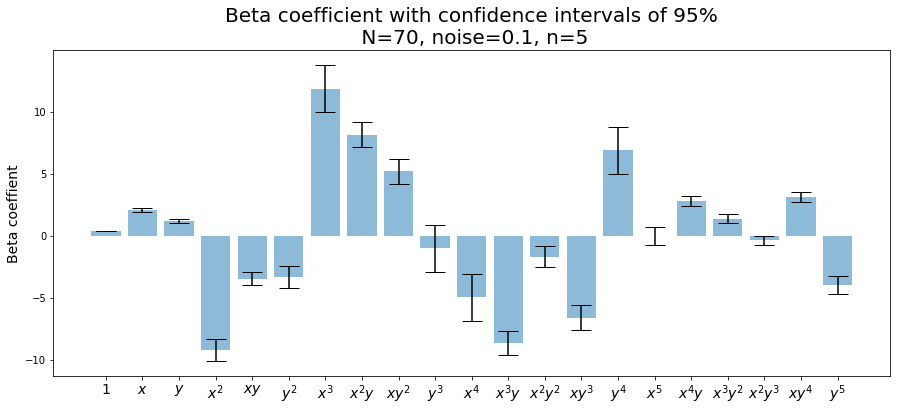

In [45]:
# Calculating the variance
betavariance = np.sqrt(np.diagonal(XTXinv)*np.var(z_train-z_tilde))

# Plotting the figure
fig, ax = plt.subplots(figsize=(15,6))

labels= ['1','$x$','$y$','$x^2$','$xy$','$y^2$','$x^3$','$x^2y$','$xy^2$','$y^3$','$x^4$',
         '$x^3y$','$x^2y^2$','$xy^3$','$y^4$','$x^5$','$x^4y$','$x^3y^2$','$x^2y^3$','$xy^4$','$y^5$']


x_pos = np.arange(len(OLSbeta))
ax.bar(x_pos, OLSbeta, yerr=2*betavariance, alpha=0.5,capsize=10)
ax.set_ylabel('Beta coeffient', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=14)
ax.set_title('Beta coefficient with confidence intervals of 95%\n N={}, noise={}, n=5'.format(N, noisefactor), fontsize=20)



fig.savefig('Results/betaconfidence.png')


plt.show()
plt.close(fig)

# Part b): Bias-variance trade-off and resampling techniques.

### Make a figure similar to Fig. 2.11 of Hasties, et al., with only the testing and training MSEs.
### Show that the cost function
### $C(\mathbf{X}, \mathbf{\beta}) = \frac{1}{n}\sum_{i=0}^{n-1}(y_i -\tilde{y_i})^2 = \mathbb{E}[(\mathbf{y}-\mathbf{\tilde{y}})^2] $
### can be rewritten as 
### $\mathbb{E}[(\mathbf{y}-\mathbf{\tilde{y}})^2] = \frac{1}{n}\sum_{i} (f_i -\mathbb{E}[\mathbf{\tilde{y}}])^2 +  \frac{1}{n}\sum_{i}(y_i -\mathbb{E}[\mathbf{\tilde{y}}])^2 + \sigma^2$

### Explain the terms, which one is bias and variance and their interpretations

### Perform bias variance tradeoff with increasing polynomials (model complexity) and number of data points, and bootstrap resampling methods on the training and testing data

# Computing the expectance of the train and test error for increasing complexity over 300 different runs

In [4]:
# Initializing the data parameters
N = 70
noisefactor = 0.1
test_size = 0.2
n =  15
iterations = 100

# Initializing the data
x, y, z = fn.init_data(N, noisefactor)

# Creating arrays for train and test error
TrainError = np.zeros(n)
TestError = np.zeros(n)

# Calculating Test and Training error over many iterations to get the expected value of train and test error.
for k in range(iterations):
    for i in range(n):
        # Creating design matrix, splitting and scaling
        X_train, X_test, z_train, z_test = fn.PreProcess(x, y, z, test_size, i)

        # Estimating the Ordinary Least Squares Beta Matrix
        # Inverting XTX matrix with SVD to avoid singular matrix
        OLSbeta = fn.SVDinv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)

        # Making the prediciton
        z_tilde = X_train @ OLSbeta
        z_predict = X_test @ OLSbeta
        
        # Computing the mean errors
        TrainError[i] += fn.MSE(z_train, z_tilde)/iterations
        TestError[i] += fn.MSE(z_test, z_predict)/iterations
    


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


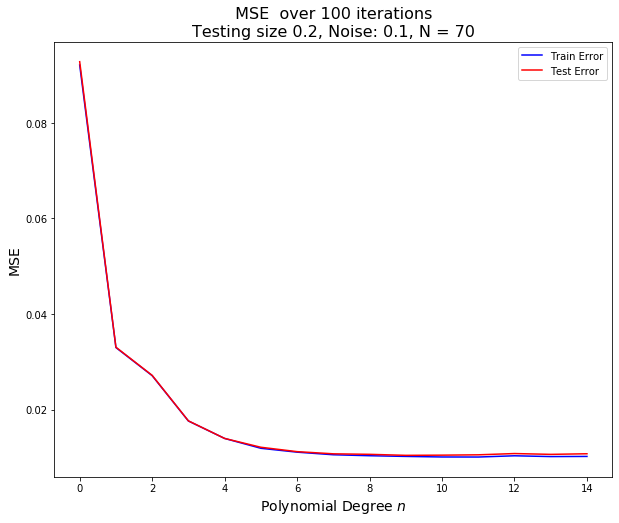

In [5]:
startpoint = 0
endpoint = 20
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(np.arange(n)[startpoint:endpoint],TrainError[startpoint:endpoint],'b' ,label='Train Error')
ax.plot(np.arange(n)[startpoint:endpoint],TestError[startpoint:endpoint],'r' ,label='Test Error')
ax.set_xlabel('Polynomial Degree $n$', fontsize=14)
ax.set_ylabel('MSE',fontsize=14)
ax.set_title(" MSE  over {0} iterations \nTesting size {1}, Noise: {2}, N = {3}".format(iterations, test_size, noisefactor, N), fontsize=16)


ax.legend()
fig.savefig('Results/MSEiterations.png')
fig.show()

## Perform bias variance tradeoff with increasing polynomials (model complexity) and number of data points, and bootstrap resampling methods on the training and testing data

### Incorporating bootstrap techniques

In [6]:
# Data Parameters
N = 70
noisefactor = 0.1
test_size = 0.2
n = 15

# Initializing the data
x, y, z = fn.init_data(N, noisefactor)
z=z.ravel()


# Intializing error bias and variance
error = np.zeros(n)
bias = np.zeros(n)
variance = np.zeros(n)

# Bootstrap parameters
n_bootstraps = 100

for i in range(n):
    # Creating design matrix, splitting and scaling
    X_train, X_test, z_train, z_test = fn.PreProcess(x, y, z, test_size, i)

    # Setting up the array for the bootstrapped predictions
    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    
    for j in range(n_bootstraps):
        x_, z_  = fn.Shuffle_Data(X_train, z_train)
        OLSbeta = fn.SVDinv(x_.T.dot(x_)).dot(x_.T).dot(z_) 
        z_pred[:,j] = X_test @ OLSbeta 

    #Reshaping
    z_test = z_test.reshape(len(z_test),1)
    
    error[i], bias[i], variance[i] = fn.ErrBiasVar(z_test, z_pred)

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


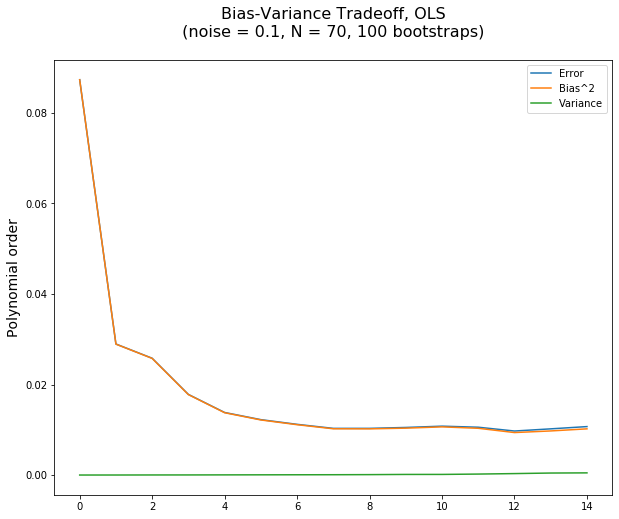

In [7]:
startpoint = 0
endpoint = 15

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(np.arange(n)[startpoint:endpoint], error[startpoint:endpoint], label='Error')
ax.plot(np.arange(n)[startpoint:endpoint], bias[startpoint:endpoint], label='Bias^2')
ax.plot(np.arange(n)[startpoint:endpoint], variance[startpoint:endpoint], label='Variance')



ax.set_ylabel("Error", fontsize=14)
ax.set_ylabel("Polynomial order",  fontsize=14)
ax.set_title("Bias-Variance Tradeoff, OLS\n (noise = {0}, N = {1}, {2} bootstraps) \n".format(noisefactor, N, n_bootstraps), fontsize =16)


#ax.set_yscale("log")
ax.legend()
plt.savefig("Results/BootstrapOLSBiasVariance.png", dpi=100)
fig.show()


# c) Cross-Validation as resampling techniques, adding more complexity.

In [8]:
# Data Parameters
N = 70
noisefactor = 0.1
n = 15

# Initializing the data
x, y, z = fn.init_data(N, noisefactor)
z = z.ravel()


# CV fold parameters 
folds = 10


# Intializing error bias and variance
error = np.zeros(n)
bias = np.zeros(n)
variance = np.zeros(n)


for i in range(n):
    # Creating design matrix for polynomial degree n
    X = fn.create_X(x,y,i)

    # Setting up the array for the k fold predictions
    foldsize = np.int(N**2/folds)        
    z_pred = np.empty((foldsize, folds))

    # Shuffling the dataset
    X, z = fn.Shuffle_Data(X,z,replacement=False)    #replacement = false means not resampling the same point twice.
    foldmask = fn.k_foldsplit(len(X),folds)

    for j in range(folds):
        X_train, z_train = X[foldmask[:,j]] , z[foldmask[:,j]]
        X_test , z_test = X[~foldmask[:,j]] , z[~foldmask[:,j]]
        #z_train = z[foldmask[:,j]]
        #z_test  = z[~foldmask[:,j]]

        # Standard scaling (subtracting the mean)
        X_train, X_test = fn.Scaling(X_train, X_test)

        # Fitting model and predicting
        OLSbeta = fn.SVDinv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train) 
        z_pred[:,j] = X_test @ OLSbeta

    #Reshaping
    z_test = z_test.reshape(len(z_test),1)

    error[i], bias[i], variance[i] = fn.ErrBiasVar(z_test, z_pred)

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


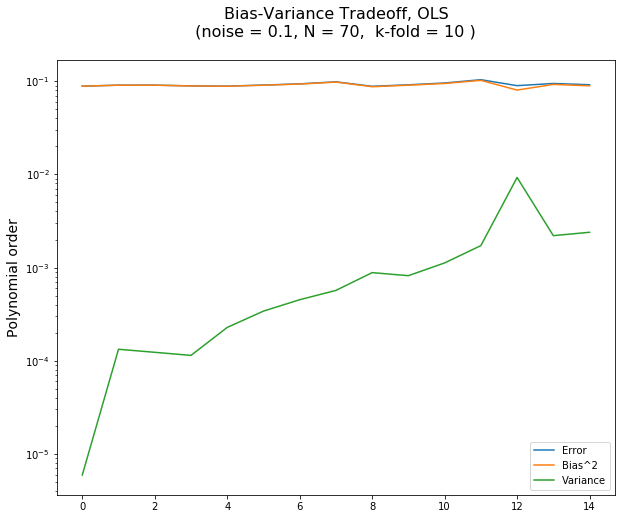

In [9]:
startpoint = 0
endpoint = 15

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(np.arange(n)[startpoint:endpoint], error[startpoint:endpoint], label='Error')
ax.plot(np.arange(n)[startpoint:endpoint], bias[startpoint:endpoint], label='Bias^2')
ax.plot(np.arange(n)[startpoint:endpoint], variance[startpoint:endpoint], label='Variance')



ax.set_ylabel("Error", fontsize=14)
ax.set_ylabel("Polynomial order",  fontsize=14)
ax.set_title("Bias-Variance Tradeoff, OLS\n (noise = {0}, N = {1},  k-fold = {2} ) \n".format(noisefactor, N, folds), fontsize =16)

ax.set_yscale("log")
ax.legend()
plt.savefig("Results/kfoldOLSBiasVariance.png", dpi=100)
fig.show()


# d) Ridge Regression on the Franke funcion with resampling

### Perform Ridge Regression with either matrix inversion or SVD.


### Use bootstrap for the same polynomial range as in b), and cross-valdiation as in c), but plotted for different values of $\lambda$

### Bootstrapping:

In [10]:
# Data Parameters
N = 70
noisefactor = 0.1
test_size = 0.2
n = 15

# Initializing the data
x, y, z = fn.init_data(N, noisefactor)


# Lambda
lamb = np.logspace(-5,2,8)

# Bootstrap parameters
n_bootstraps = 50


# Intializing error bias and variance
error = np.zeros((len(lamb),n))
bias = np.zeros((len(lamb),n))
variance = np.zeros((len(lamb),n))



for k in range(len(lamb)):
    print("Lamdba equals {}".format(lamb[k]))
    for i in range(n):
            
        # Creating design matrix, splitting and scaling
        X_train, X_test, z_train, z_test = fn.PreProcess(x, y, z, test_size, i)

        # Setting up the array for the bootstrapped predictions
        z_pred = np.empty((z_test.shape[0], n_bootstraps))

        for j in range(n_bootstraps):
            x_, z_  = fn.Shuffle_Data(X_train, z_train)
            RIDGEbeta = fn.SVDinv(x_.T.dot(x_)+lamb[k]*np.eye(len(X_train[0]))).dot(x_.T).dot(z_) 

            z_pred[:,j] = X_test @ RIDGEbeta 

        #Reshaping
        z_test = z_test.reshape(len(z_test),1)


        error[k,i], bias[k,i], variance[k,i] = fn.ErrBiasVar(z_test, z_pred)

Lamdba equals 1e-05
Lamdba equals 0.0001
Lamdba equals 0.001
Lamdba equals 0.01
Lamdba equals 0.1
Lamdba equals 1.0
Lamdba equals 10.0
Lamdba equals 100.0


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20:

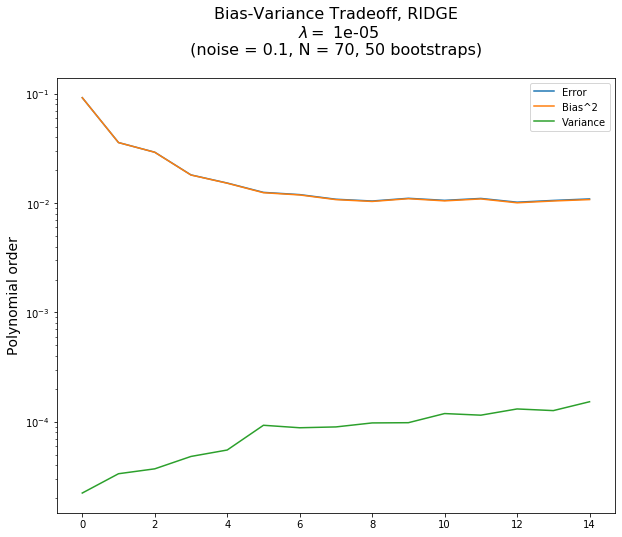

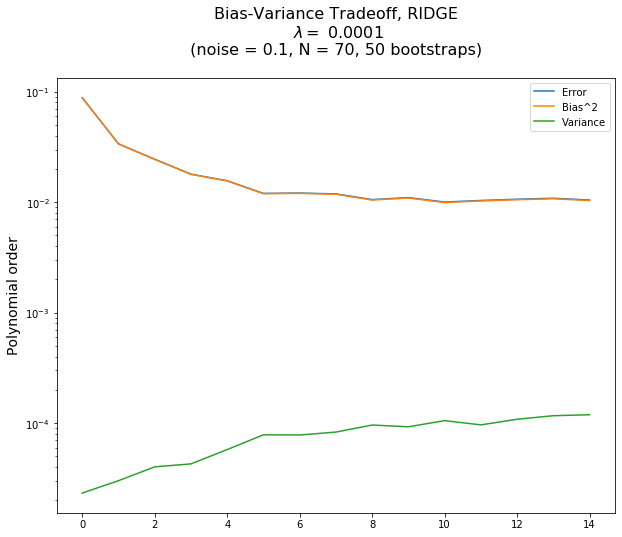

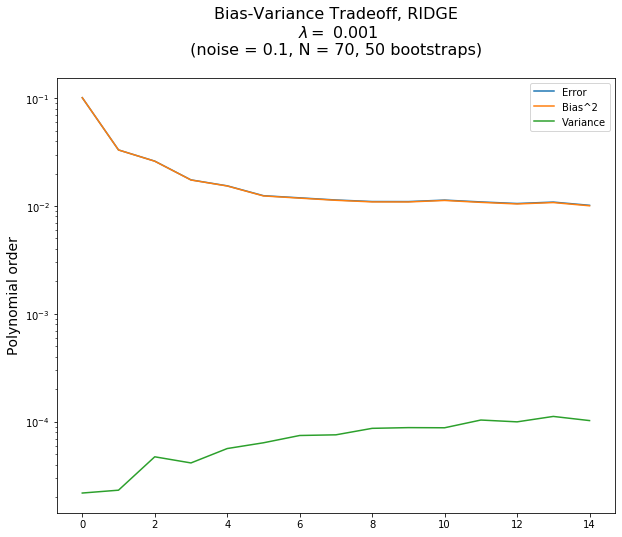

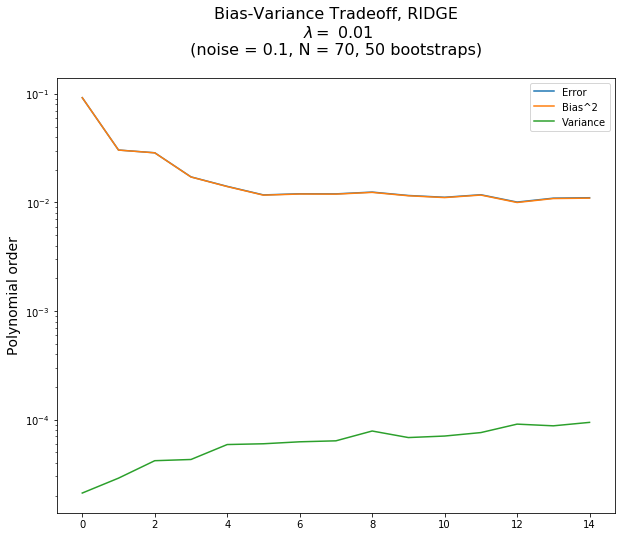

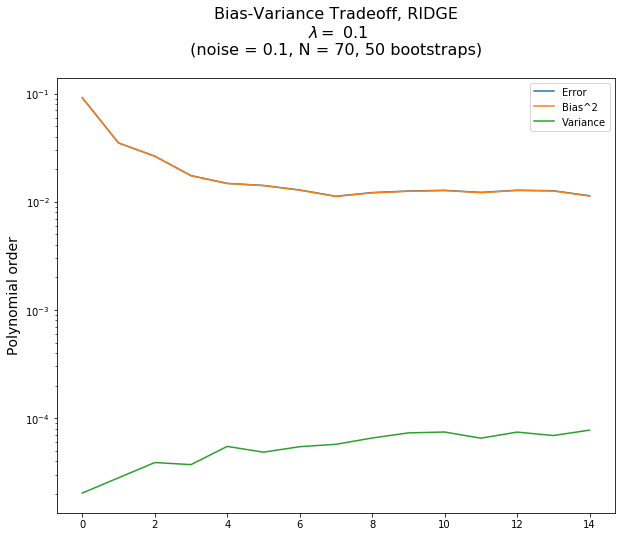

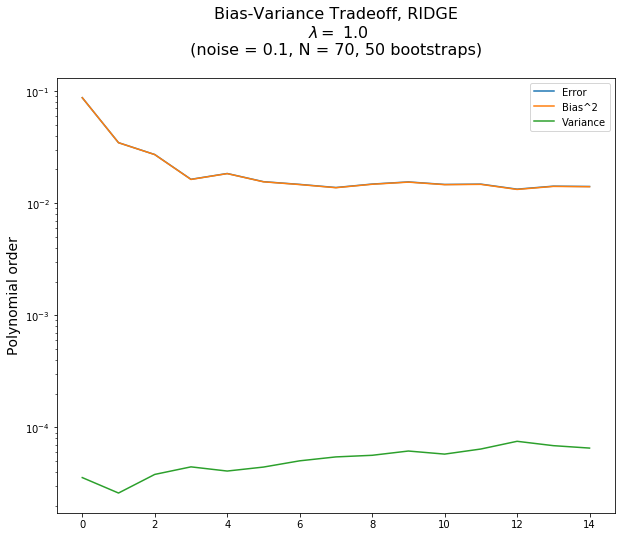

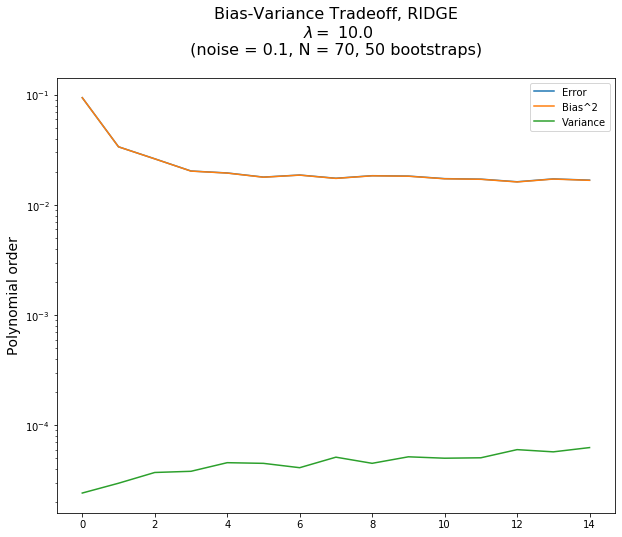

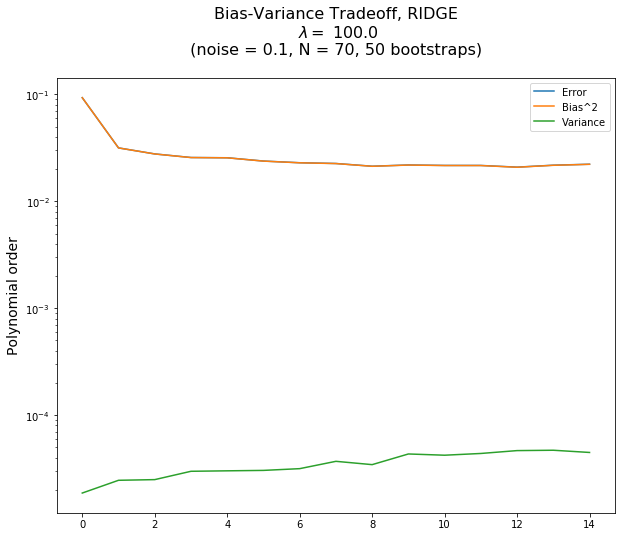

In [11]:
startpoint = 0
endpoint = 15
for k in range(len(lamb)):
    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(np.arange(n)[startpoint:endpoint], error[k,startpoint:endpoint], label='Error')
    ax.plot(np.arange(n)[startpoint:endpoint], bias[k,startpoint:endpoint], label='Bias^2')
    ax.plot(np.arange(n)[startpoint:endpoint], variance[k,startpoint:endpoint], label='Variance')



    ax.set_ylabel("Error", fontsize=14)
    ax.set_ylabel("Polynomial order",  fontsize=14)
    ax.set_title("Bias-Variance Tradeoff, RIDGE\n $\lambda=$ {0}\n (noise = {1}, N = {2}, {3} bootstraps) \n".format(lamb[k],noisefactor, N, n_bootstraps), fontsize =16)


    ax.set_yscale("log")
    ax.legend()
    #plt.savefig("Results/BootstrapOLSBiasVariance.png", dpi=100)
    fig.show()


## k fold cross validation

In [12]:
# Data Parameters
N = 70
noisefactor = 0.1
n = 15

# Initializing the data
x, y, z = fn.init_data(N, noisefactor)
z = z.ravel()

# penalty term
lamb = np.logspace(-5,0,6)

# CV fold parameters 
folds = 5


# Intializing error bias and variance
error = np.zeros((len(lamb),n))
bias = np.zeros((len(lamb),n))
variance = np.zeros((len(lamb),n))


for k in range(len(lamb)):
    print("Lamdba equals {}".format(lamb[k]))
    for i in range(n):
        # Creating design matrix for polynomial degree n
        X = fn.create_X(x,y,i)
        
        # Setting up the array for the k fold predictions
        foldsize = np.int(N**2/folds)        
        z_pred = np.empty((foldsize, folds))
        
        # Shuffling the dataset
        X, z = fn.Shuffle_Data(X,z,replacement=False)    #replacement = false means not resampling the same point twice.
        foldmask = fn.k_foldsplit(len(X),folds)
        
        for j in range(folds):
            X_train, z_train = X[foldmask[:,j]] , z[foldmask[:,j]]
            X_test , z_test = X[~foldmask[:,j]] , z[~foldmask[:,j]]
            #z_train = z[foldmask[:,j]]
            #z_test  = z[~foldmask[:,j]]
            
            # Standard scaling (subtracting the mean)
            X_train, X_test = fn.Scaling(X_train, X_test)
            
            # Fitting model and predicting
            RIDGEbeta = fn.SVDinv(X_train.T.dot(X_train)+lamb[k]*np.eye(len(X_train[0]))).dot(X_train.T).dot(z_train) 
            z_pred[:,j] = X_test @ RIDGEbeta

        #Reshaping
        z_test = z_test.reshape(len(z_test),1)

        error[k,i], bias[k,i], variance[k,i] = fn.ErrBiasVar(z_test, z_pred)

Lamdba equals 1e-05
Lamdba equals 0.0001
Lamdba equals 0.001
Lamdba equals 0.01
Lamdba equals 0.1
Lamdba equals 1.0


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20:

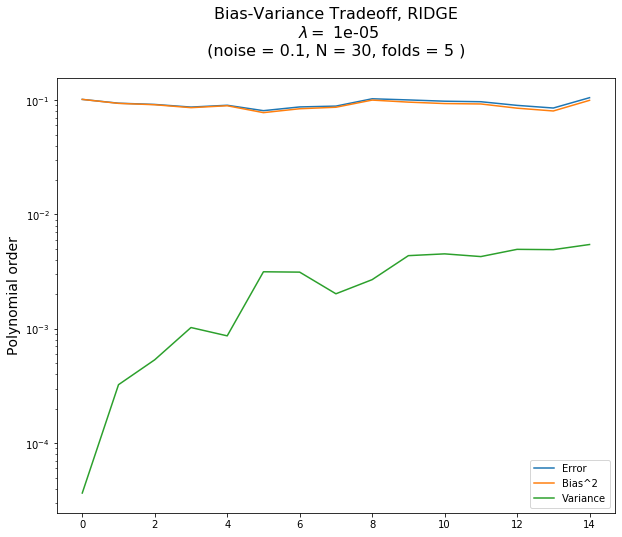

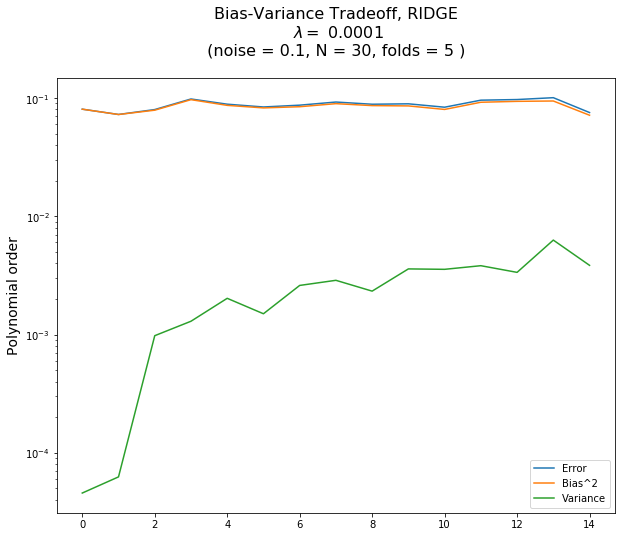

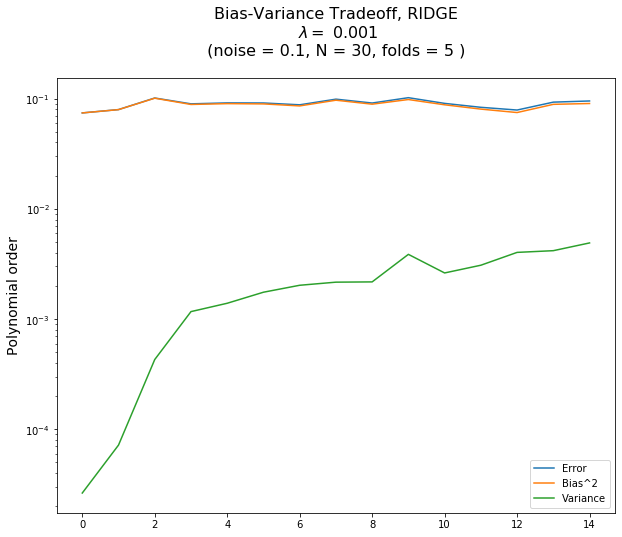

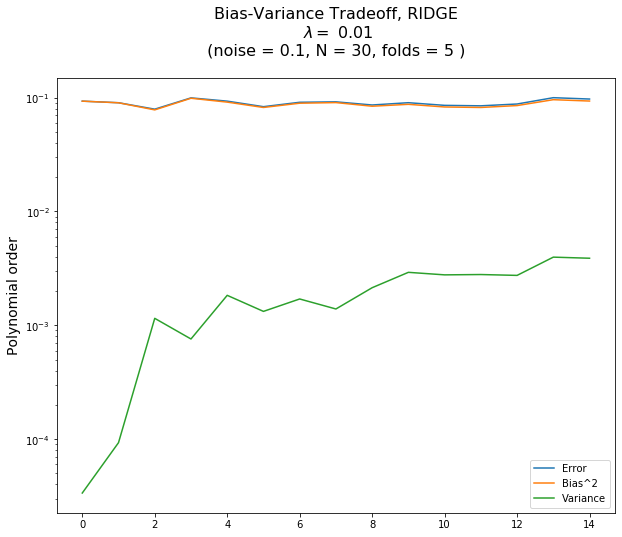

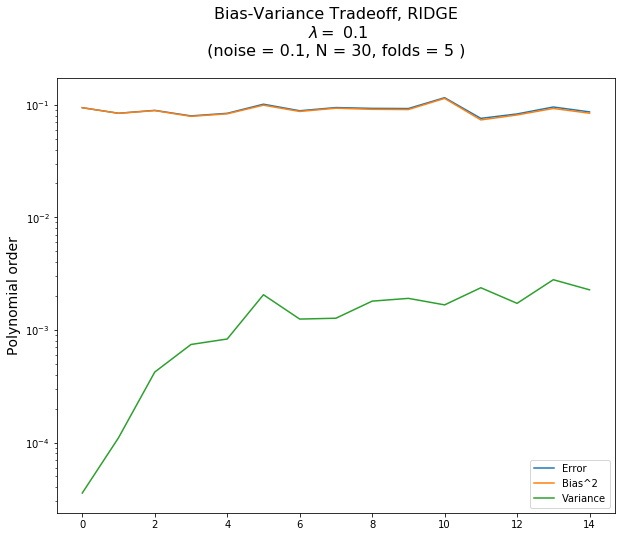

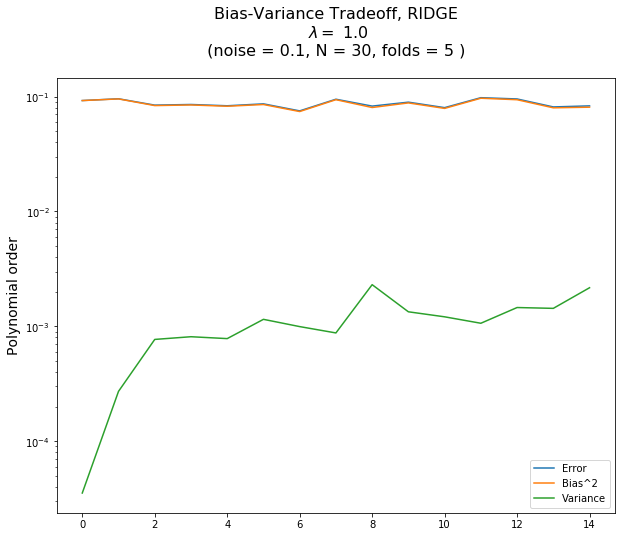

In [13]:
startpoint = 0
endpoint = 15
for k in range(len(lamb)):
    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(np.arange(n)[startpoint:endpoint], error[k,startpoint:endpoint], label='Error')
    ax.plot(np.arange(n)[startpoint:endpoint], bias[k,startpoint:endpoint], label='Bias^2')
    ax.plot(np.arange(n)[startpoint:endpoint], variance[k,startpoint:endpoint], label='Variance')



    ax.set_ylabel("Error", fontsize=14)
    ax.set_ylabel("Polynomial order",  fontsize=14)
    ax.set_title("Bias-Variance Tradeoff, RIDGE\n $\lambda=$ {0}\n (noise = {1}, N = {2}, folds = {3} ) \n".format(lamb[k],noisefactor, N, folds), fontsize =16)


    ax.set_yscale("log")
    ax.legend()
    #plt.savefig("Results/BootstrapOLSBiasVariance.png", dpi=100)
    fig.show()


# e) Lasso Regression on the Franke function with resampling

### Perform Lasso Regression with Scikit-Learn.
### Use bootstrap for the same polynomial range as in b), and cross-valdiation as in c), but plotted for different values of $\lambda$
### Give a critical discussion of the three methods and a judgement of which model fits the data best.

In [14]:
from sklearn import linear_model
# Data Parameters
N = 70
noisefactor = 0.1
test_size = 0.2
n = 6

# Initializing the data
x, y, z = fn.init_data(N, noisefactor)

# Lambda
lamb = np.logspace(-5,0,6)
# Bootstrap parameters
n_bootstraps = 10

# Intializing error bias and variance
error = np.zeros((len(lamb),n))
bias = np.zeros((len(lamb),n))
variance = np.zeros((len(lamb),n))

for k in range(len(lamb)):
    print("Lamdba equals {}".format(lamb[k]))

    for i in range(n):
        print("n equals {}".format(i))
        # Creating design matrix, splitting and scaling
        X_train, X_test, z_train, z_test = fn.PreProcess(x, y, z, test_size, i)

        # Setting up the array for the bootstrapped predictions
        z_pred = np.empty((z_test.shape[0], n_bootstraps))

        for j in range(n_bootstraps):
            x_, z_  = fn.Shuffle_Data(X_train, z_train)

            # Lasso regression
            clf = linear_model.Lasso(alpha=lamb[k], fit_intercept=False, max_iter=100000, tol=0.01)
            clf.fit(x_, z_)
            LASSObeta = clf.coef_
            z_pred[:,j] = X_test @ LASSObeta 
            
        
        
        
        
        #Reshaping
        z_test = z_test.reshape(len(z_test),1)


        error[k,i], bias[k,i], variance[k,i] = fn.ErrBiasVar(z_test, z_pred)

Lamdba equals 1e-05
n equals 0
n equals 1
n equals 2
n equals 3
n equals 4
n equals 5


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9144181103512308, tolerance: 1.755661245733415
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9366488655656222, tolerance: 1.7529010892745225
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.43903126037974, tolerance: 1.8580519557419262
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objecti

Lamdba equals 0.0001
n equals 0
n equals 1
n equals 2
n equals 3
n equals 4
n equals 5
Lamdba equals 0.001
n equals 0
n equals 1
n equals 2
n equals 3
n equals 4
n equals 5
Lamdba equals 0.01
n equals 0
n equals 1
n equals 2
n equals 3
n equals 4
n equals 5
Lamdba equals 0.1
n equals 0
n equals 1
n equals 2
n equals 3
n equals 4
n equals 5
Lamdba equals 1.0
n equals 0
n equals 1
n equals 2
n equals 3
n equals 4
n equals 5


Text(0.5, 15.0, '$\\lambda$')

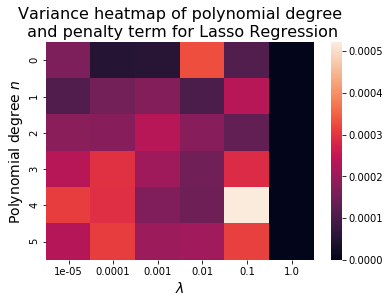

In [15]:
import seaborn as sns
ax = sns.heatmap(variance.T, xticklabels=lamb)
ax.set_title('Variance heatmap of polynomial degree\n and penalty term for Lasso Regression',fontsize = 16)
ax.set_ylabel('Polynomial degree $n$',fontsize = 14)
ax.set_xlabel('$\lambda$',fontsize = 14)

Text(0.5, 15.0, '$\\lambda$')

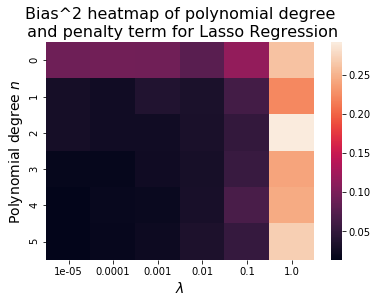

In [16]:
import seaborn as sns
ax = sns.heatmap(bias.T, xticklabels=lamb)
ax.set_title('Bias^2 heatmap of polynomial degree\n and penalty term for Lasso Regression',fontsize = 16)
ax.set_ylabel('Polynomial degree $n$',fontsize = 14)
ax.set_xlabel('$\lambda$',fontsize = 14)

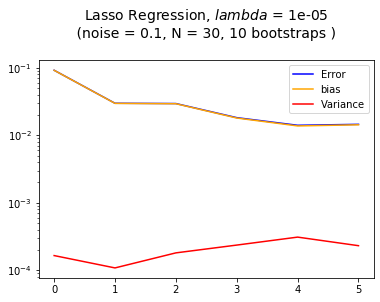

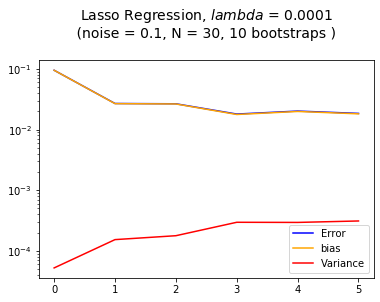

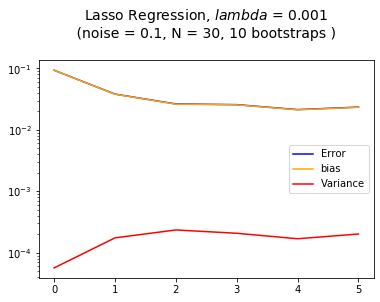

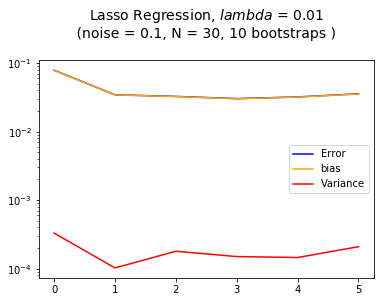

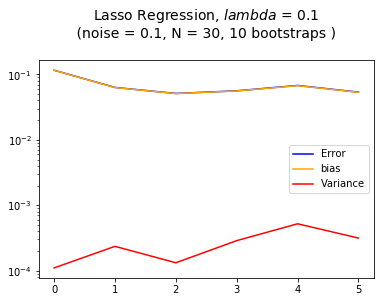

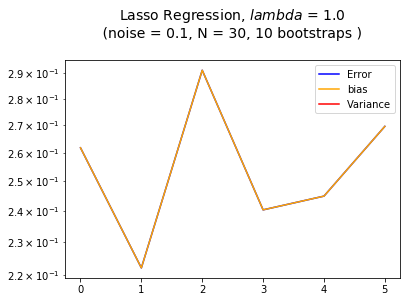

In [17]:
startpoint = 0
endpoint = 15
for k in range(len(lamb)):
    plt.plot(np.arange(n)[startpoint:endpoint], error[k,startpoint:endpoint], color='blue', label='Error')
    plt.plot(np.arange(n)[startpoint:endpoint], bias[k,startpoint:endpoint], color = 'orange', label='bias')
    plt.plot(np.arange(n)[startpoint:endpoint], variance[k,startpoint:endpoint], color ='red', label='Variance')
    plt.title("Lasso Regression, $lambda$ = {0}\n (noise = {1}, N = {2}, {3} bootstraps ) \n".format(lamb[k], noisefactor, N, n_bootstraps), fontsize =14)
    plt.legend()
    plt.yscale("log")

    plt.show()

## k-fold cross validation

In [18]:
# Data Parameters
N = 70
noisefactor = 0.3
n = 15

# Initializing the data
x, y, z = fn.init_data(N, noisefactor)
z = z.ravel()

# penalty term
lamb = np.logspace(-5,0,6)

# CV fold parameters 
folds = 10


# Intializing error bias and variance
error = np.zeros((len(lamb),n))
bias = np.zeros((len(lamb),n))
variance = np.zeros((len(lamb),n))


for k in range(len(lamb)):
    print("Lamdba equals {}".format(lamb[k]))
    for i in range(n):
        # Creating design matrix for polynomial degree n
        X = fn.create_X(x,y,i)
        
        # Setting up the array for the k fold predictions
        foldsize = np.int(N**2/folds)        
        z_pred = np.empty((foldsize, folds))
        
        # Shuffling the dataset
        X, z = fn.Shuffle_Data(X,z,replacement=False)    #replacement = false means not resampling the same point twice.
        foldmask = fn.k_foldsplit(len(X),folds)
        
        for j in range(folds):
            X_train, z_train = X[foldmask[:,j]] , z[foldmask[:,j]]
            X_test , z_test = X[~foldmask[:,j]] , z[~foldmask[:,j]]

            
            # Standard scaling (subtracting the mean)
            X_train, X_test = fn.Scaling(X_train, X_test)
            
            # Fitting model and predicting
            clf = linear_model.Lasso(alpha=lamb[k], fit_intercept=False, max_iter=500, tol=0.001)
            clf.fit(X_train, z_train)
            LASSObeta = clf.coef_
            z_pred[:,j] = X_test @ LASSObeta

        #Reshaping
        z_test = z_test.reshape(len(z_test),1)

        error[k,i], bias[k,i], variance[k,i] = fn.ErrBiasVar(z_test, z_pred)

Lamdba equals 1e-05


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.16281002882915, tolerance: 0.25289374661803665
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.033635488596104, tolerance: 0.2551693504124654
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.91043797727174, tolerance: 0.25698177640007897
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.91367539180086, tolerance: 0.26061984136584204
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.540760204851516, tolerance: 0.25453462146665945
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.72210553030766, tolerance: 0.253821429900723
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objec

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.93454820232119, tolerance: 0.2632067735923711
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.785374528576845, tolerance: 0.25145947405778746
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.33158824887039, tolerance: 0.2556082695575732
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objec

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.67498052663273, tolerance: 0.2464350374353282
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.20146477227934, tolerance: 0.2616941354574202
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.06710199632244, tolerance: 0.2588231278392886
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objecti

Lamdba equals 0.0001


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.890724867374537, tolerance: 0.2555750396036555
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.92855349613815, tolerance: 0.24817775196234637
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.446303247828716, tolerance: 0.24592628087756702
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obj

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.162396202110976, tolerance: 0.25981340654125995
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.6260603835688, tolerance: 0.26274753584671473
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.6516682399758, tolerance: 0.25237002856294344
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objec

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.074781326407276, tolerance: 0.2573875998600601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.50318933522258, tolerance: 0.25494124473848306
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.469821432250946, tolerance: 0.2493630077307402
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

Lamdba equals 0.001


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2539075642842761, tolerance: 0.2516556224621633
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5337984115080445, tolerance: 0.2583103437669964
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3890802307608823, tolerance: 0.24786711549809357
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obj

Lamdba equals 0.01
Lamdba equals 0.1
Lamdba equals 1.0


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20:

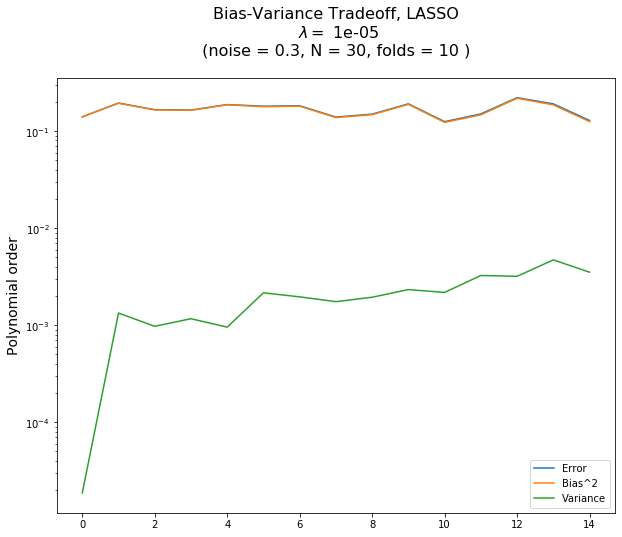

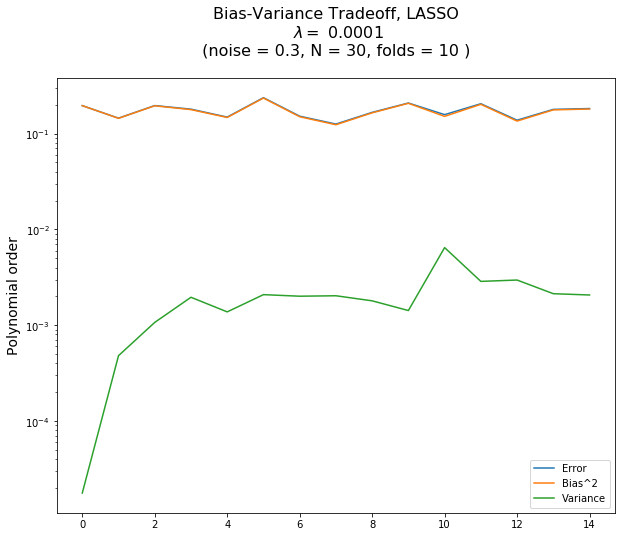

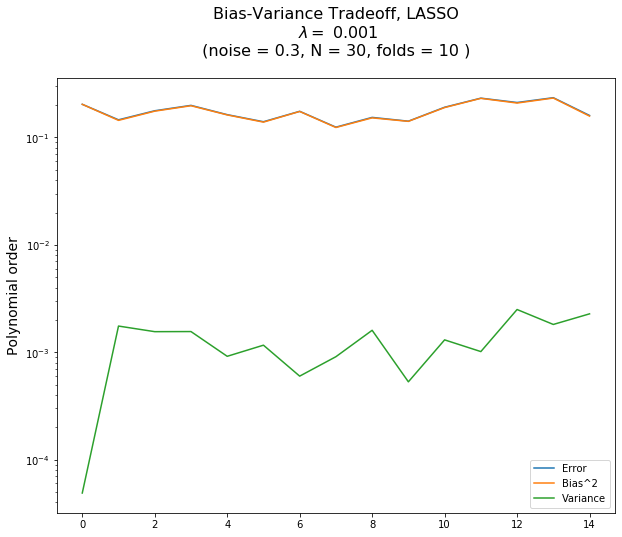

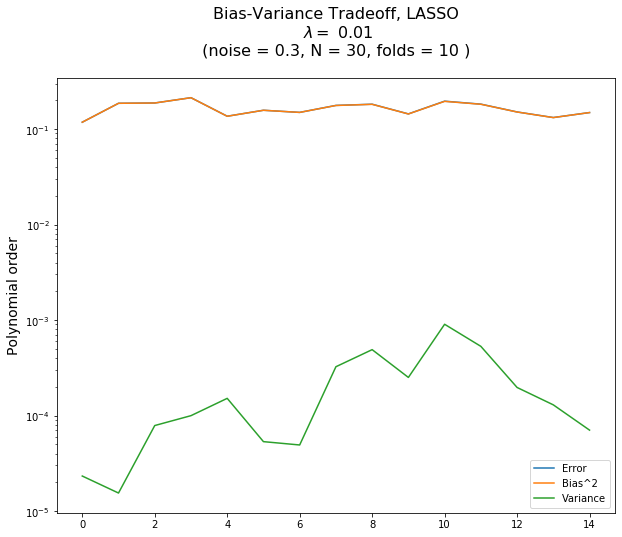

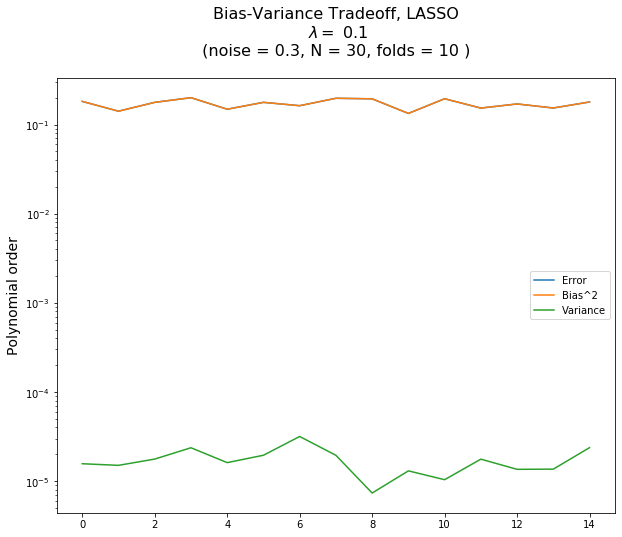

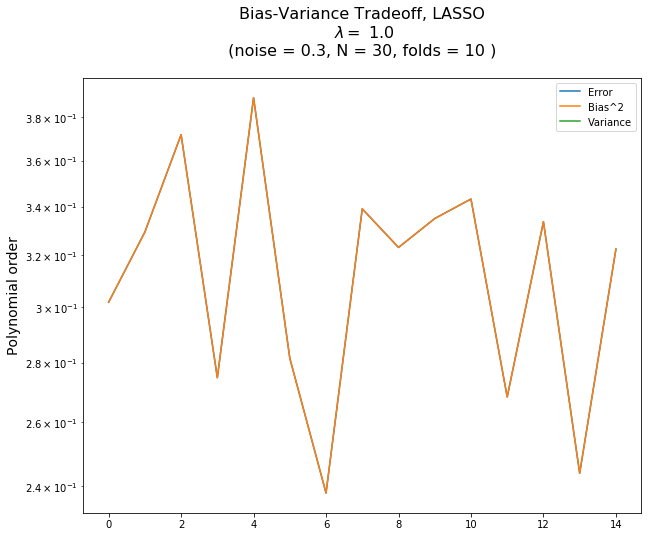

In [19]:
startpoint = 0
endpoint = 15
for k in range(len(lamb)):
    fig, ax = plt.subplots(figsize=(10,8))

    ax.plot(np.arange(n)[startpoint:endpoint], error[k,startpoint:endpoint], label='Error')
    ax.plot(np.arange(n)[startpoint:endpoint], bias[k,startpoint:endpoint], label='Bias^2')
    ax.plot(np.arange(n)[startpoint:endpoint], variance[k,startpoint:endpoint], label='Variance')



    ax.set_ylabel("Error", fontsize=14)
    ax.set_ylabel("Polynomial order",  fontsize=14)
    ax.set_title("Bias-Variance Tradeoff, LASSO\n $\lambda=$ {0}\n (noise = {1}, N = {2}, folds = {3} ) \n".format(lamb[k],noisefactor, N, folds), fontsize =16)


    ax.set_yscale("log")
    ax.legend()
    #plt.savefig("Results/BootstrapOLSBiasVariance.png", dpi=100)
    fig.show()


# f) Introducing real data and preparing the data analysis

### Get data from data folder of project 1. 

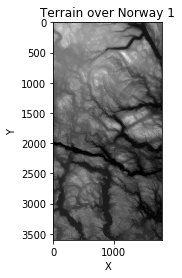

In [20]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# Load the terrain
terrain1 = imread("SRTM_data_Norway.tif")
# Show the terrain
plt.figure()
plt.title("Terrain over Norway 1")
plt.imshow(terrain1, cmap="gray")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [21]:
# Initializing the data
x_start, x_end = 2300,2500
y_start, y_end = 600,1100
Z = fn.terrainInit("SRTM_data_Norway.tif", x_start, x_end, y_start, y_end)

# Reducing the resolution of the data down to N x N datapoints.
N = 70
x, y = np.linspace(0,1,N), np.linspace(0,1,N)
Z = fn.terrain_sampling(x,y,Z)

x, y = np.meshgrid(x,y)


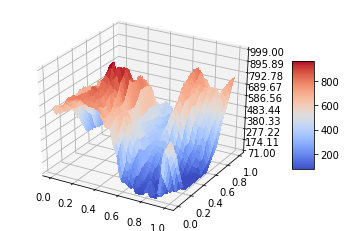

In [23]:
# Plotting the terrain
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(x, y, Z, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)


# Customize the z axis.
#ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# g) OLS, Ridge and Lasso regression with resampling

### Apply all three methods on the terrain data, with the same polynomial approximation and cross-validation as resampling technique to evaluate which model fits the data best.
### "Present a critical evaluation of your results and disucss the applicability of these regreesion methods to the type of the data presented here (either the terrain data we propose or other data sets)."

MSE Train error 5866.00515207011
MSE Test error 6269.882890858146


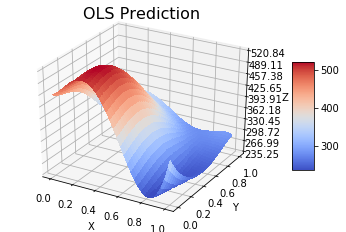

In [24]:
# Initializing the data
N = 70
test_size = 0.2
n =  5

# Creating design matrix, splitting and scaling
X_train, X_test, z_train, z_test = fn.PreProcess(x, y, Z, test_size, n)

# Estimating the Ordinary Least Squares Beta Matrix
# Inverting XTX matrix with SVD to avoid singular matrix
OLSbeta = fn.SVDinv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)

# Making the prediciton
z_tilde = X_train @ OLSbeta
z_predict = X_test @ OLSbeta

# Computing the mean errors
print('MSE Train error',fn.MSE(z_train, z_tilde) )
print('MSE Test error',fn.MSE(z_test, z_predict) )


fn.surfplotter(x,y,OLSbeta, n, 'OLS Prediction')

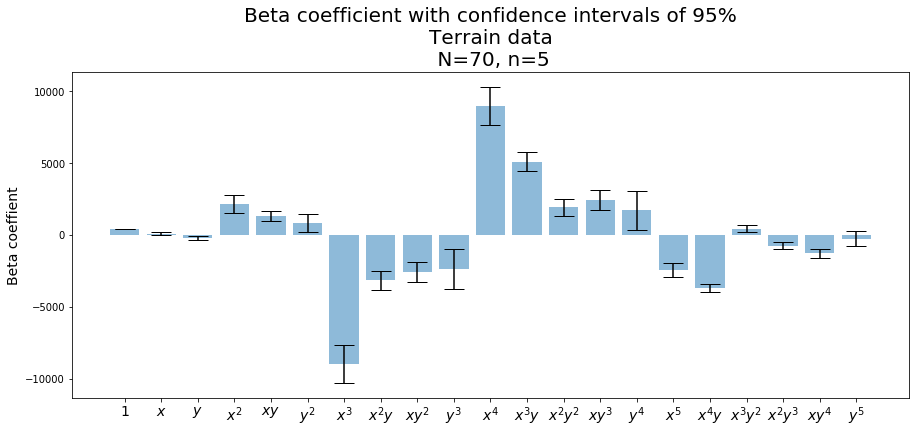

In [25]:
# Calculating the variance
betavariance = np.sqrt(np.diagonal(fn.SVDinv(X_train.T.dot(X_train)))*np.var(z_train-z_tilde))

# Plotting the figure
fig, ax = plt.subplots(figsize=(15,6))

labels= ['1','$x$','$y$','$x^2$','$xy$','$y^2$','$x^3$','$x^2y$','$xy^2$','$y^3$','$x^4$',
         '$x^3y$','$x^2y^2$','$xy^3$','$y^4$','$x^5$','$x^4y$','$x^3y^2$','$x^2y^3$','$xy^4$','$y^5$']


x_pos = np.arange(len(OLSbeta))
ax.bar(x_pos, OLSbeta, yerr=2*betavariance, alpha=0.5,capsize=10)
ax.set_ylabel('Beta coeffient', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=14)
ax.set_title('Beta coefficient with confidence intervals of 95%\nTerrain data\n N={}, n=5'.format(N), fontsize=20)



#fig.savefig('Results/betaconfidence.png')


plt.show()
plt.close(fig)

# OLS:

In [27]:
# Initializing the data
N = 70
test_size = 0.2
n =  15
iterations = 50

# Creating arrays for train and test error
TrainError = np.zeros(n)
TestError = np.zeros(n)
for j in range(iterations):
    for i in range(n):
        # Creating design matrix, splitting and scaling
        X_train, X_test, z_train, z_test = fn.PreProcess(x, y, Z, test_size, i)

        # Estimating the Ordinary Least Squares Beta Matrix
        # Inverting XTX matrix with SVD to avoid singular matrix
        OLSbeta = fn.SVDinv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)


        # Making the prediciton
        z_tilde = X_train @ OLSbeta
        z_predict = X_test @ OLSbeta


        
        # Computing the mean errors
        TrainError[i] += fn.MSE(z_train, z_tilde)/iterations
        TestError[i]  += fn.MSE(z_test, z_predict)/iterations



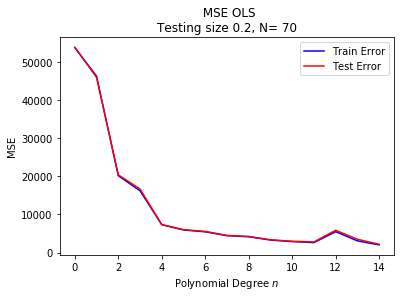

In [28]:
startpoint = 0
endpoint = n

plt.plot(np.arange(n)[startpoint:endpoint],TrainError[startpoint:endpoint],'b' ,label='Train Error')
plt.plot(np.arange(n)[startpoint:endpoint],TestError[startpoint:endpoint],'r' ,label='Test Error')
plt.xlabel('Polynomial Degree $n$')
plt.ylabel('MSE')
plt.title(" MSE OLS\nTesting size {0}, N= {1}".format(test_size, N))

plt.legend()

# Ridge

### [RIDGE] Plotting prediction on surface only using test train split for distinct $\lambda$ and $n$

MSE Train error 4478.872913668368
MSE Test error 4351.263277378907


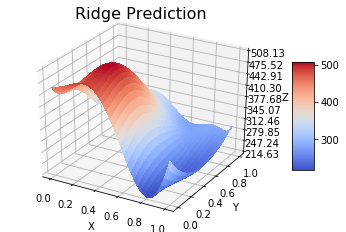

In [29]:
# Initializing the data
N = 70
test_size = 0.2
n =  10
lamb = 1e-4

# Creating design matrix, splitting and scaling
X_train, X_test, z_train, z_test = fn.PreProcess(x, y, Z, test_size, n)


# Estimating the Ordinary Least Squares Beta Matrix
# Inverting XTX matrix with SVD to avoid singular matrix
RIDGEbeta = fn.SVDinv((X_train.T.dot(X_train)+lamb*np.eye(X_train[0].shape[0]))).dot(X_train.T).dot(z_train)

# Making the prediciton
z_tilde = X_train @ RIDGEbeta
z_predict = X_test @ RIDGEbeta

# Computing the mean errors
print('MSE Train error',fn.MSE(z_train, z_tilde) )
print('MSE Test error',fn.MSE(z_test, z_predict) )


fn.surfplotter(x,y,RIDGEbeta,n, 'Ridge Prediction')


<BarContainer object of 66 artists>

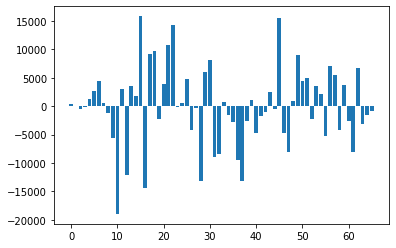

In [30]:
plt.bar(np.arange(len(RIDGEbeta)),RIDGEbeta)

## [RIDGE] Bootstrap - Bias Variance on Terrain Data

In [31]:
# Initializing the data
N = 70
test_size = 0.2
n =  15

# Lambda
lamb = 10**np.linspace(-5,0,6)

# Bootstrap parameters
n_bootstraps = 100

# Intializing error bias and variance
error = np.zeros((len(lamb),n))
bias = np.zeros((len(lamb),n))
variance = np.zeros((len(lamb),n))

for k in range(len(lamb)):
    print("Lamdba equals {}".format(lamb[k]))
    for i in range(n):
            
        # Creating design matrix, splitting and scaling
        X_train, X_test, z_train, z_test = fn.PreProcess(x, y, Z, test_size, i)

        # Setting up the array for the bootstrapped predictions
        z_pred = np.empty((z_test.shape[0], n_bootstraps))

        for j in range(n_bootstraps):
            x_, z_  = fn.Shuffle_Data(X_train, z_train)
            RIDGEbeta = fn.SVDinv(x_.T.dot(x_)+lamb[k]*np.eye(len(X_train[0]))).dot(x_.T).dot(z_) 

            z_pred[:,j] = X_test @ RIDGEbeta 

        #Reshaping
        z_test = z_test.reshape(len(z_test),1)


        error[k,i], bias[k,i], variance[k,i] = fn.ErrBiasVar(z_test, z_pred)

Lamdba equals 1e-05
Lamdba equals 0.0001
Lamdba equals 0.001
Lamdba equals 0.01
Lamdba equals 0.1
Lamdba equals 1.0


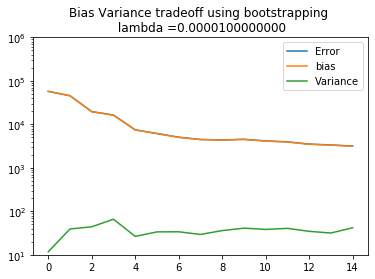

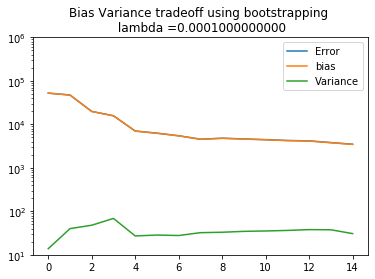

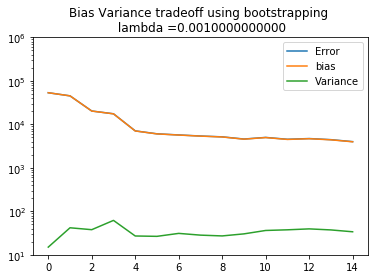

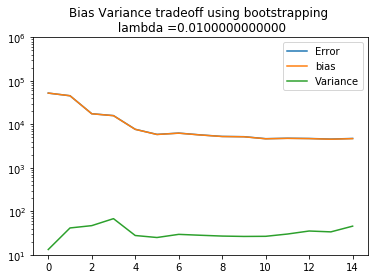

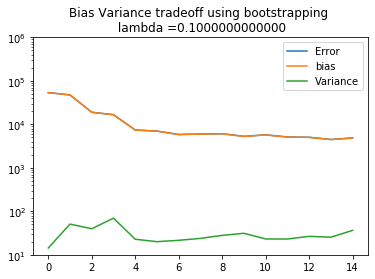

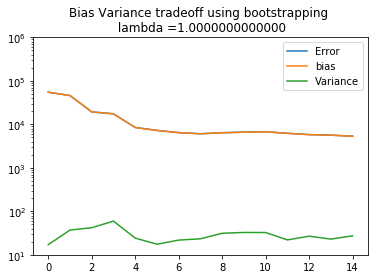

In [32]:
startpoint = 0
endpoint = 20

for k in range(len(lamb)):
    

    plt.plot(np.arange(n)[startpoint:endpoint], error[k,startpoint:endpoint], label='Error')
    plt.plot(np.arange(n)[startpoint:endpoint], bias[k,startpoint:endpoint], label='bias')
    plt.plot(np.arange(n)[startpoint:endpoint], variance[k,startpoint:endpoint], label='Variance')
    plt.title("Bias Variance tradeoff using bootstrapping \n lambda =%.13f" % lamb[k])
    plt.legend()
    plt.yscale("log")
    plt.ylim(10, 1000000)
    plt.show()

## [RIDGE] k-fold cross validation  - Bias Variance on Terrain Data

In [33]:
# Initializing the data
N = 70
test_size = 0.2
n =  15


# Lambda
lamb = 10**np.linspace(-5,0,6)

# CV fold parameters 
folds = 5
foldsize = np.int(N**2/folds) 

# Intializing error bias and variance
error = np.zeros((len(lamb),n))
bias = np.zeros((len(lamb),n))
variance = np.zeros((len(lamb),n))


for k in range(len(lamb)):
    print("Lamdba equals {}".format(lamb[k]))
    for i in range(n):
        
        # Creating design matrix for polynomial degree n
        X = fn.create_X(x,y,i)
        
        # Setting up the array for the k fold predictions
        z_pred = np.empty((foldsize, folds))
        
        # Shuffling the dataset
        X, z = fn.Shuffle_Data(X,Z.ravel(),replacement=False)    #replacement = false means not resampling the same point twice.
        
        # Getting the index for array for the folds and the rest
        foldmask = fn.k_foldsplit(len(X),folds)
        
        for j in range(folds):
            X_train, z_train = X[foldmask[:,j]] , z[foldmask[:,j]]
            X_test , z_test = X[~foldmask[:,j]] , z[~foldmask[:,j]]
            
            # Standard scaling
            X_train, X_test = fn.Scaling(X_train, X_test)
            
            # Fitting model and predicting
            RIDGEbeta = fn.SVDinv(X_train.T.dot(X_train)+lamb[k]*np.eye(len(X_train[0]))).dot(X_train.T).dot(z_train) 
            z_pred[:,j] = X_test @ RIDGEbeta

        #Reshaping
        z_test = z_test.reshape(len(z_test),1)


        error[k,i], bias[k,i], variance[k,i] = fn.ErrBiasVar(z_test, z_pred)

Lamdba equals 1e-05
Lamdba equals 0.0001
Lamdba equals 0.001
Lamdba equals 0.01
Lamdba equals 0.1
Lamdba equals 1.0


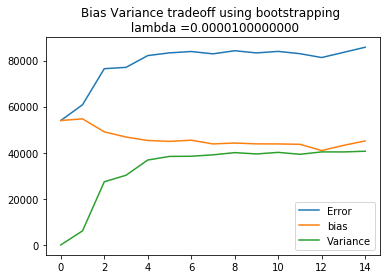

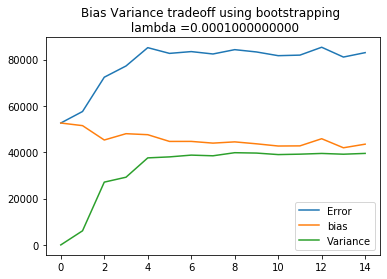

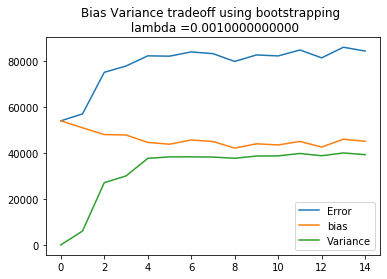

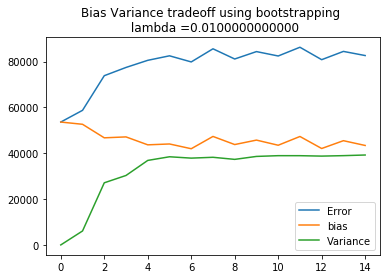

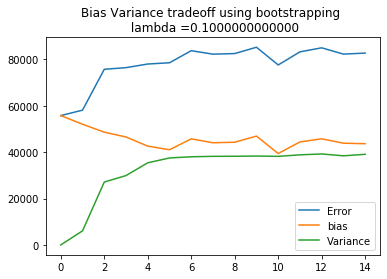

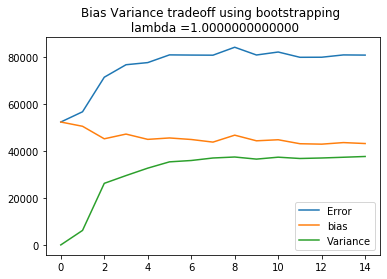

In [34]:
startpoint = 0
endpoint = 20

for k in range(len(lamb)):
    

    plt.plot(np.arange(n)[startpoint:endpoint], error[k,startpoint:endpoint], label='Error')
    plt.plot(np.arange(n)[startpoint:endpoint], bias[k,startpoint:endpoint], label='bias')
    plt.plot(np.arange(n)[startpoint:endpoint], variance[k,startpoint:endpoint], label='Variance')
    plt.title("Bias Variance tradeoff using bootstrapping \n lambda =%.13f" % lamb[k])
    plt.legend()
    #plt.ylim(-0.01, 0.1)
    plt.show()

# Lasso

### [LASSO] Plotting prediction on surface only using test train split for distinct $\lambda$ and $n$

MSE Train error 6214.197688105783
MSE Test error 6435.341005525327


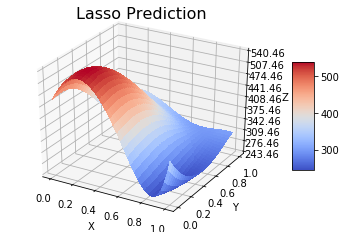

In [35]:
# Initializing the data
N = 70
test_size = 0.2
n =  10
lamb = 0.1

# Creating design matrix, splitting and scaling
X_train, X_test, z_train, z_test = fn.PreProcess(x, y, Z, test_size, n)


# Lasso regression
clf = linear_model.Lasso(alpha=lamb, fit_intercept=False, max_iter=200000, tol=1e-5)
clf.fit(X_train, z_train)
LASSObeta = clf.coef_
 

# Making the prediciton
z_tilde = X_train @ LASSObeta
z_predict = X_test @ LASSObeta

# Computing the mean errors
print('MSE Train error',fn.MSE(z_train, z_tilde) )
print('MSE Test error',fn.MSE(z_test, z_predict) )


fn.surfplotter(x,y,LASSObeta,n, 'Lasso Prediction')


<BarContainer object of 66 artists>

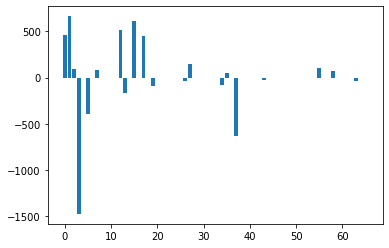

In [36]:
plt.bar(np.arange(len(LASSObeta)),LASSObeta)

## Bootstrap

In [38]:
# Initializing the data
N = 70
test_size = 0.2
n =  15

# Reducing the resolution of the data down to N x N datapoints.
x, y = np.linspace(0,1,N), np.linspace(0,1,N)
z = fn.terrain_sampling(x,y,Z)

x,y = np.meshgrid(x,y)

# Lambda
lamb = 10**np.linspace(-5,0,6)

# Bootstrap parameters
n_bootstraps = 100


# Intializing error bias and variance
error = np.zeros((len(lamb),n))
bias = np.zeros((len(lamb),n))
variance = np.zeros((len(lamb),n))



for k in range(len(lamb)):
    print("Lamdba equals {}".format(lamb[k]))
    for i in range(n):
            
        # Creating design matrix, splitting and scaling
        X_train, X_test, z_train, z_test = fn.PreProcess(x, y, z, test_size, i)

        # Setting up the array for the bootstrapped predictions
        z_pred = np.empty((z_test.shape[0], n_bootstraps))

        for j in range(n_bootstraps):
            x_, z_  = fn.Shuffle_Data(X_train, z_train)
            clf = linear_model.Lasso(alpha=lamb[k], fit_intercept=False, max_iter=500, tol=0.001)
            clf.fit(X_train, z_train)
            LASSObeta = clf.coef_
            z_pred[:,j] = X_test @ LASSObeta 

        #Reshaping
        z_test = z_test.reshape(len(z_test),1)


        error[k,i], bias[k,i], variance[k,i] = fn.ErrBiasVar(z_test, z_pred)

Lamdba equals 1e-05


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33217355.139336005, tolerance: 1030121.184
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33217355.139336005, tolerance: 1030121.184
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33217355.139336005, tolerance: 1030121.184
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33217355.139336005, tolerance: 1030121.184
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33217355.139336005, tolerance: 1030121.184
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33217355.139336005, tolerance: 1030121.184
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33217355.139336005, tolerance: 1030121.184
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33217355.139336005, tolerance: 1030121.184
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33217355.139336005, tolerance: 1030121.184
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33217355.139336005, tolerance: 1030121.184
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33217355.139336005, tolerance: 1030121.184
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33217355.139336005, tolerance: 1030121.184
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20039542.329251572, tolerance: 1022417.7490000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20039542.329251572, tolerance: 1022417.7490000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20039542.329251572, tolerance: 1022417.7490000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20039542.329251572, tolerance: 1022417.7490000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20039542.329251572, tolerance: 1022417.7490000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20039542.329251572, tolerance: 1022417.7490000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20039542.329251572, tolerance: 1022417.7490000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20039542.329251572, tolerance: 1022417.7490000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20039542.329251572, tolerance: 1022417.7490000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16748072.814599512, tolerance: 1046994.3030000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16748072.814599512, tolerance: 1046994.3030000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16748072.814599512, tolerance: 1046994.3030000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16748072.814599512, tolerance: 1046994.3030000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16748072.814599512, tolerance: 1046994.3030000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16748072.814599512, tolerance: 1046994.3030000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16748072.814599512, tolerance: 1046994.3030000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16748072.814599512, tolerance: 1046994.3030000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16748072.814599512, tolerance: 1046994.3030000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15611763.097056447, tolerance: 1032569.42
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15611763.097056447, tolerance: 1032569.42
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15611763.097056447, tolerance: 1032569.42
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15611763.097056447, tolerance: 1032569.42
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15611763.097056447, tolerance: 1032569.42
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15611763.097056447, tolerance: 1032569.42
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15611763.097056447, tolerance: 1032569.42
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15611763.097056447, tolerance: 1032569.42
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15611763.097056447, tolerance: 1032569.42
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14250041.98829194, tolerance: 1035516.925
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14250041.98829194, tolerance: 1035516.925
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14250041.98829194, tolerance: 1035516.925
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14250041.98829194, tolerance: 1035516.925
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14250041.98829194, tolerance: 1035516.925
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14250041.98829194, tolerance: 1035516.925
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14250041.98829194, tolerance: 1035516.925
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14250041.98829194, tolerance: 1035516.925
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14250041.98829194, tolerance: 1035516.925
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13717820.879560051, tolerance: 1033915.128
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13717820.879560051, tolerance: 1033915.128
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13717820.879560051, tolerance: 1033915.128
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13717820.879560051, tolerance: 1033915.128
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13717820.879560051, tolerance: 1033915.128
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13717820.879560051, tolerance: 1033915.128
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13717820.879560051, tolerance: 1033915.128
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13717820.879560051, tolerance: 1033915.128
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13717820.879560051, tolerance: 1033915.128
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13567023.3678081, tolerance: 1038873.214
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13567023.3678081, tolerance: 1038873.214
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13567023.3678081, tolerance: 1038873.214
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13567023.3678081, tolerance: 1038873.214
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13567023.3678081, tolerance: 1038873.214
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13567023.3678081, tolerance: 1038873.214
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13567023.3678081, tolerance: 1038873.214
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13567023.3678081, tolerance: 1038873.214
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13567023.3678081, tolerance: 1038873.214
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13567023.3678081, tolerance: 1038873.214
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13567023.3678081, tolerance: 1038873.214
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13567023.3678081, tolerance: 1038873.214
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13557387.51871151, tolerance: 1028237.241
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13557387.51871151, tolerance: 1028237.241
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13557387.51871151, tolerance: 1028237.241
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13557387.51871151, tolerance: 1028237.241
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13557387.51871151, tolerance: 1028237.241
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13557387.51871151, tolerance: 1028237.241
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13557387.51871151, tolerance: 1028237.241
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13557387.51871151, tolerance: 1028237.241
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13557387.51871151, tolerance: 1028237.241
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13605865.408726642, tolerance: 1031063.951
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13605865.408726642, tolerance: 1031063.951
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13605865.408726642, tolerance: 1031063.951
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13605865.408726642, tolerance: 1031063.951
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13605865.408726642, tolerance: 1031063.951
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13605865.408726642, tolerance: 1031063.951
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13605865.408726642, tolerance: 1031063.951
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13605865.408726642, tolerance: 1031063.951
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13605865.408726642, tolerance: 1031063.951
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13910906.302725503, tolerance: 1037536.707
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13910906.302725503, tolerance: 1037536.707
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13910906.302725503, tolerance: 1037536.707
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13910906.302725503, tolerance: 1037536.707
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13910906.302725503, tolerance: 1037536.707
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13910906.302725503, tolerance: 1037536.707
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13910906.302725503, tolerance: 1037536.707
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13910906.302725503, tolerance: 1037536.707
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13910906.302725503, tolerance: 1037536.707
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13910906.302725503, tolerance: 1037536.707
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13910906.302725503, tolerance: 1037536.707
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13910906.302725503, tolerance: 1037536.707
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13743076.621727237, tolerance: 1040312.54
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13743076.621727237, tolerance: 1040312.54
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13743076.621727237, tolerance: 1040312.54
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13743076.621727237, tolerance: 1040312.54
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13743076.621727237, tolerance: 1040312.54
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13743076.621727237, tolerance: 1040312.54
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13743076.621727237, tolerance: 1040312.54
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13743076.621727237, tolerance: 1040312.54
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13743076.621727237, tolerance: 1040312.54
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13539198.37836094, tolerance: 1042368.079
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13539198.37836094, tolerance: 1042368.079
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13539198.37836094, tolerance: 1042368.079
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13539198.37836094, tolerance: 1042368.079
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13539198.37836094, tolerance: 1042368.079
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13539198.37836094, tolerance: 1042368.079
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13539198.37836094, tolerance: 1042368.079
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13539198.37836094, tolerance: 1042368.079
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13539198.37836094, tolerance: 1042368.079
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

Lamdba equals 0.0001


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33118826.869845457, tolerance: 1032695.4180000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33118826.869845457, tolerance: 1032695.4180000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33118826.869845457, tolerance: 1032695.4180000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33118826.869845457, tolerance: 1032695.4180000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33118826.869845457, tolerance: 1032695.4180000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33118826.869845457, tolerance: 1032695.4180000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33118826.869845457, tolerance: 1032695.4180000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33118826.869845457, tolerance: 1032695.4180000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33118826.869845457, tolerance: 1032695.4180000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33118826.869845457, tolerance: 1032695.4180000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33118826.869845457, tolerance: 1032695.4180000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33118826.869845457, tolerance: 1032695.4180000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19833086.307128582, tolerance: 1031879.481
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19833086.307128582, tolerance: 1031879.481
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19833086.307128582, tolerance: 1031879.481
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19833086.307128582, tolerance: 1031879.481
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19833086.307128582, tolerance: 1031879.481
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19833086.307128582, tolerance: 1031879.481
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19833086.307128582, tolerance: 1031879.481
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19833086.307128582, tolerance: 1031879.481
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19833086.307128582, tolerance: 1031879.481
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16774554.402981648, tolerance: 1039410.017
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16774554.402981648, tolerance: 1039410.017
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16774554.402981648, tolerance: 1039410.017
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16774554.402981648, tolerance: 1039410.017
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16774554.402981648, tolerance: 1039410.017
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16774554.402981648, tolerance: 1039410.017
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16774554.402981648, tolerance: 1039410.017
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16774554.402981648, tolerance: 1039410.017
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16774554.402981648, tolerance: 1039410.017
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15196845.992082553, tolerance: 1031502.431
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15196845.992082553, tolerance: 1031502.431
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15196845.992082553, tolerance: 1031502.431
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15196845.992082553, tolerance: 1031502.431
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15196845.992082553, tolerance: 1031502.431
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15196845.992082553, tolerance: 1031502.431
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15196845.992082553, tolerance: 1031502.431
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15196845.992082553, tolerance: 1031502.431
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15196845.992082553, tolerance: 1031502.431
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14384928.302500956, tolerance: 1025719.599
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14384928.302500956, tolerance: 1025719.599
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14384928.302500956, tolerance: 1025719.599
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14384928.302500956, tolerance: 1025719.599
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14384928.302500956, tolerance: 1025719.599
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14384928.302500956, tolerance: 1025719.599
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14384928.302500956, tolerance: 1025719.599
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14384928.302500956, tolerance: 1025719.599
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14384928.302500956, tolerance: 1025719.599
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13948469.927310245, tolerance: 1024925.437
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13948469.927310245, tolerance: 1024925.437
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13948469.927310245, tolerance: 1024925.437
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13948469.927310245, tolerance: 1024925.437
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13948469.927310245, tolerance: 1024925.437
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13948469.927310245, tolerance: 1024925.437
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13948469.927310245, tolerance: 1024925.437
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13948469.927310245, tolerance: 1024925.437
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13948469.927310245, tolerance: 1024925.437
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13457601.541450394, tolerance: 1035221.502
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13457601.541450394, tolerance: 1035221.502
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13457601.541450394, tolerance: 1035221.502
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13457601.541450394, tolerance: 1035221.502
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13457601.541450394, tolerance: 1035221.502
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13457601.541450394, tolerance: 1035221.502
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13457601.541450394, tolerance: 1035221.502
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13457601.541450394, tolerance: 1035221.502
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13457601.541450394, tolerance: 1035221.502
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13457601.541450394, tolerance: 1035221.502
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13457601.541450394, tolerance: 1035221.502
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13457601.541450394, tolerance: 1035221.502
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814419.149805406, tolerance: 1042041.689
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814419.149805406, tolerance: 1042041.689
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814419.149805406, tolerance: 1042041.689
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814419.149805406, tolerance: 1042041.689
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814419.149805406, tolerance: 1042041.689
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814419.149805406, tolerance: 1042041.689
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814419.149805406, tolerance: 1042041.689
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814419.149805406, tolerance: 1042041.689
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814419.149805406, tolerance: 1042041.689
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13697472.26122507, tolerance: 1039810.688
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13697472.26122507, tolerance: 1039810.688
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13697472.26122507, tolerance: 1039810.688
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13697472.26122507, tolerance: 1039810.688
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13697472.26122507, tolerance: 1039810.688
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13697472.26122507, tolerance: 1039810.688
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13697472.26122507, tolerance: 1039810.688
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13697472.26122507, tolerance: 1039810.688
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13697472.26122507, tolerance: 1039810.688
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13961810.598777486, tolerance: 1035321.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13961810.598777486, tolerance: 1035321.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13961810.598777486, tolerance: 1035321.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13961810.598777486, tolerance: 1035321.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13961810.598777486, tolerance: 1035321.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13961810.598777486, tolerance: 1035321.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13961810.598777486, tolerance: 1035321.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13961810.598777486, tolerance: 1035321.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13961810.598777486, tolerance: 1035321.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13797696.996258575, tolerance: 1033913.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13797696.996258575, tolerance: 1033913.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13797696.996258575, tolerance: 1033913.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13797696.996258575, tolerance: 1033913.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13797696.996258575, tolerance: 1033913.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13797696.996258575, tolerance: 1033913.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13797696.996258575, tolerance: 1033913.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13797696.996258575, tolerance: 1033913.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13797696.996258575, tolerance: 1033913.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13797696.996258575, tolerance: 1033913.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13797696.996258575, tolerance: 1033913.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13797696.996258575, tolerance: 1033913.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13546597.778109461, tolerance: 1032982.111
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13546597.778109461, tolerance: 1032982.111
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13546597.778109461, tolerance: 1032982.111
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13546597.778109461, tolerance: 1032982.111
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13546597.778109461, tolerance: 1032982.111
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13546597.778109461, tolerance: 1032982.111
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13546597.778109461, tolerance: 1032982.111
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13546597.778109461, tolerance: 1032982.111
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13546597.778109461, tolerance: 1032982.111
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

Lamdba equals 0.001


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32762252.189390354, tolerance: 1030077.578
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32762252.189390354, tolerance: 1030077.578
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32762252.189390354, tolerance: 1030077.578
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32762252.189390354, tolerance: 1030077.578
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32762252.189390354, tolerance: 1030077.578
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32762252.189390354, tolerance: 1030077.578
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32762252.189390354, tolerance: 1030077.578
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32762252.189390354, tolerance: 1030077.578
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32762252.189390354, tolerance: 1030077.578
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32762252.189390354, tolerance: 1030077.578
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32762252.189390354, tolerance: 1030077.578
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19877317.776159737, tolerance: 1041203.196
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19877317.776159737, tolerance: 1041203.196
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19877317.776159737, tolerance: 1041203.196
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19877317.776159737, tolerance: 1041203.196
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19877317.776159737, tolerance: 1041203.196
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19877317.776159737, tolerance: 1041203.196
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19877317.776159737, tolerance: 1041203.196
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19877317.776159737, tolerance: 1041203.196
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19877317.776159737, tolerance: 1041203.196
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19877317.776159737, tolerance: 1041203.196
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16512428.960807374, tolerance: 1034913.3960000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16512428.960807374, tolerance: 1034913.3960000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16512428.960807374, tolerance: 1034913.3960000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16512428.960807374, tolerance: 1034913.3960000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16512428.960807374, tolerance: 1034913.3960000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16512428.960807374, tolerance: 1034913.3960000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16512428.960807374, tolerance: 1034913.3960000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16512428.960807374, tolerance: 1034913.3960000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16512428.960807374, tolerance: 1034913.3960000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15664369.236834599, tolerance: 1032261.122
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15664369.236834599, tolerance: 1032261.122
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15664369.236834599, tolerance: 1032261.122
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15664369.236834599, tolerance: 1032261.122
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15664369.236834599, tolerance: 1032261.122
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15664369.236834599, tolerance: 1032261.122
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15664369.236834599, tolerance: 1032261.122
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15664369.236834599, tolerance: 1032261.122
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15664369.236834599, tolerance: 1032261.122
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14672917.695874017, tolerance: 1037951.479
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14672917.695874017, tolerance: 1037951.479
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14672917.695874017, tolerance: 1037951.479
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14672917.695874017, tolerance: 1037951.479
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14672917.695874017, tolerance: 1037951.479
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14672917.695874017, tolerance: 1037951.479
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14672917.695874017, tolerance: 1037951.479
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14672917.695874017, tolerance: 1037951.479
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14672917.695874017, tolerance: 1037951.479
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13905673.762934916, tolerance: 1032445.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13905673.762934916, tolerance: 1032445.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13905673.762934916, tolerance: 1032445.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13905673.762934916, tolerance: 1032445.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13905673.762934916, tolerance: 1032445.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13905673.762934916, tolerance: 1032445.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13905673.762934916, tolerance: 1032445.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13905673.762934916, tolerance: 1032445.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13905673.762934916, tolerance: 1032445.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13487325.121324306, tolerance: 1029622.728
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13487325.121324306, tolerance: 1029622.728
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13487325.121324306, tolerance: 1029622.728
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13487325.121324306, tolerance: 1029622.728
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13487325.121324306, tolerance: 1029622.728
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13487325.121324306, tolerance: 1029622.728
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13487325.121324306, tolerance: 1029622.728
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13487325.121324306, tolerance: 1029622.728
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13487325.121324306, tolerance: 1029622.728
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13487325.121324306, tolerance: 1029622.728
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13487325.121324306, tolerance: 1029622.728
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13487325.121324306, tolerance: 1029622.728
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13661260.52986756, tolerance: 1029328.034
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13661260.52986756, tolerance: 1029328.034
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13661260.52986756, tolerance: 1029328.034
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13661260.52986756, tolerance: 1029328.034
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13661260.52986756, tolerance: 1029328.034
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13661260.52986756, tolerance: 1029328.034
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13661260.52986756, tolerance: 1029328.034
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13661260.52986756, tolerance: 1029328.034
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13661260.52986756, tolerance: 1029328.034
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814566.236907786, tolerance: 1044106.27
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814566.236907786, tolerance: 1044106.27
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814566.236907786, tolerance: 1044106.27
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814566.236907786, tolerance: 1044106.27
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814566.236907786, tolerance: 1044106.27
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814566.236907786, tolerance: 1044106.27
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814566.236907786, tolerance: 1044106.27
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814566.236907786, tolerance: 1044106.27
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13814566.236907786, tolerance: 1044106.27
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13778677.674022105, tolerance: 1044271.667
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13778677.674022105, tolerance: 1044271.667
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13778677.674022105, tolerance: 1044271.667
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13778677.674022105, tolerance: 1044271.667
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13778677.674022105, tolerance: 1044271.667
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13778677.674022105, tolerance: 1044271.667
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13778677.674022105, tolerance: 1044271.667
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13778677.674022105, tolerance: 1044271.667
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13778677.674022105, tolerance: 1044271.667
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13503886.628009915, tolerance: 1041564.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13503886.628009915, tolerance: 1041564.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13503886.628009915, tolerance: 1041564.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13503886.628009915, tolerance: 1041564.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13503886.628009915, tolerance: 1041564.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13503886.628009915, tolerance: 1041564.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13503886.628009915, tolerance: 1041564.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13503886.628009915, tolerance: 1041564.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13503886.628009915, tolerance: 1041564.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13503886.628009915, tolerance: 1041564.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13503886.628009915, tolerance: 1041564.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13503886.628009915, tolerance: 1041564.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13632287.887740592, tolerance: 1035160.405
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13632287.887740592, tolerance: 1035160.405
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13632287.887740592, tolerance: 1035160.405
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13632287.887740592, tolerance: 1035160.405
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13632287.887740592, tolerance: 1035160.405
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13632287.887740592, tolerance: 1035160.405
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13632287.887740592, tolerance: 1035160.405
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13632287.887740592, tolerance: 1035160.405
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13632287.887740592, tolerance: 1035160.405
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

Lamdba equals 0.01


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32148906.466715228, tolerance: 1033388.408
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32148906.466715228, tolerance: 1033388.408
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32148906.466715228, tolerance: 1033388.408
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32148906.466715228, tolerance: 1033388.408
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32148906.466715228, tolerance: 1033388.408
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32148906.466715228, tolerance: 1033388.408
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32148906.466715228, tolerance: 1033388.408
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32148906.466715228, tolerance: 1033388.408
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32148906.466715228, tolerance: 1033388.408
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32148906.466715228, tolerance: 1033388.408
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32148906.466715228, tolerance: 1033388.408
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32148906.466715228, tolerance: 1033388.408
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19348646.122082092, tolerance: 1031307.5210000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19348646.122082092, tolerance: 1031307.5210000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19348646.122082092, tolerance: 1031307.5210000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19348646.122082092, tolerance: 1031307.5210000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19348646.122082092, tolerance: 1031307.5210000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19348646.122082092, tolerance: 1031307.5210000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19348646.122082092, tolerance: 1031307.5210000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19348646.122082092, tolerance: 1031307.5210000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19348646.122082092, tolerance: 1031307.5210000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16057395.595062584, tolerance: 1039684.7170000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16057395.595062584, tolerance: 1039684.7170000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16057395.595062584, tolerance: 1039684.7170000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16057395.595062584, tolerance: 1039684.7170000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16057395.595062584, tolerance: 1039684.7170000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16057395.595062584, tolerance: 1039684.7170000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16057395.595062584, tolerance: 1039684.7170000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16057395.595062584, tolerance: 1039684.7170000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16057395.595062584, tolerance: 1039684.7170000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14982877.041880164, tolerance: 1027384.495
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14982877.041880164, tolerance: 1027384.495
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14982877.041880164, tolerance: 1027384.495
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14982877.041880164, tolerance: 1027384.495
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14982877.041880164, tolerance: 1027384.495
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14982877.041880164, tolerance: 1027384.495
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14982877.041880164, tolerance: 1027384.495
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14982877.041880164, tolerance: 1027384.495
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14982877.041880164, tolerance: 1027384.495
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14509814.75276426, tolerance: 1051924.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14509814.75276426, tolerance: 1051924.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14509814.75276426, tolerance: 1051924.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14509814.75276426, tolerance: 1051924.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14509814.75276426, tolerance: 1051924.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14509814.75276426, tolerance: 1051924.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14509814.75276426, tolerance: 1051924.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14509814.75276426, tolerance: 1051924.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14509814.75276426, tolerance: 1051924.545
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13682873.390522318, tolerance: 1034706.525
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13682873.390522318, tolerance: 1034706.525
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13682873.390522318, tolerance: 1034706.525
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13682873.390522318, tolerance: 1034706.525
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13682873.390522318, tolerance: 1034706.525
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13682873.390522318, tolerance: 1034706.525
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13682873.390522318, tolerance: 1034706.525
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13682873.390522318, tolerance: 1034706.525
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13682873.390522318, tolerance: 1034706.525
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13122739.833141202, tolerance: 1029424.387
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13122739.833141202, tolerance: 1029424.387
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13122739.833141202, tolerance: 1029424.387
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13122739.833141202, tolerance: 1029424.387
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13122739.833141202, tolerance: 1029424.387
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13122739.833141202, tolerance: 1029424.387
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13122739.833141202, tolerance: 1029424.387
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13122739.833141202, tolerance: 1029424.387
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13122739.833141202, tolerance: 1029424.387
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13122739.833141202, tolerance: 1029424.387
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13263243.100496668, tolerance: 1031923.215
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13263243.100496668, tolerance: 1031923.215
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13263243.100496668, tolerance: 1031923.215
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13263243.100496668, tolerance: 1031923.215
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13263243.100496668, tolerance: 1031923.215
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13263243.100496668, tolerance: 1031923.215
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13263243.100496668, tolerance: 1031923.215
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13263243.100496668, tolerance: 1031923.215
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13263243.100496668, tolerance: 1031923.215
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13263243.100496668, tolerance: 1031923.215
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13263243.100496668, tolerance: 1031923.215
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13098954.142077988, tolerance: 1035570.917
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13098954.142077988, tolerance: 1035570.917
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13098954.142077988, tolerance: 1035570.917
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13098954.142077988, tolerance: 1035570.917
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13098954.142077988, tolerance: 1035570.917
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13098954.142077988, tolerance: 1035570.917
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13098954.142077988, tolerance: 1035570.917
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13098954.142077988, tolerance: 1035570.917
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13098954.142077988, tolerance: 1035570.917
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13035390.162870917, tolerance: 1026312.841
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13035390.162870917, tolerance: 1026312.841
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13035390.162870917, tolerance: 1026312.841
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13035390.162870917, tolerance: 1026312.841
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13035390.162870917, tolerance: 1026312.841
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13035390.162870917, tolerance: 1026312.841
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13035390.162870917, tolerance: 1026312.841
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13035390.162870917, tolerance: 1026312.841
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13035390.162870917, tolerance: 1026312.841
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13184467.441502942, tolerance: 1039312.26
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13184467.441502942, tolerance: 1039312.26
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13184467.441502942, tolerance: 1039312.26
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13184467.441502942, tolerance: 1039312.26
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13184467.441502942, tolerance: 1039312.26
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13184467.441502942, tolerance: 1039312.26
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13184467.441502942, tolerance: 1039312.26
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13184467.441502942, tolerance: 1039312.26
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13184467.441502942, tolerance: 1039312.26
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13184467.441502942, tolerance: 1039312.26
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13184467.441502942, tolerance: 1039312.26
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13184467.441502942, tolerance: 1039312.26
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13553149.007162374, tolerance: 1043447.7270000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13553149.007162374, tolerance: 1043447.7270000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13553149.007162374, tolerance: 1043447.7270000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13553149.007162374, tolerance: 1043447.7270000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13553149.007162374, tolerance: 1043447.7270000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13553149.007162374, tolerance: 1043447.7270000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13553149.007162374, tolerance: 1043447.7270000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13553149.007162374, tolerance: 1043447.7270000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13553149.007162374, tolerance: 1043447.7270000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

Lamdba equals 0.1


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24076572.278416716, tolerance: 1032376.702
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24076572.278416716, tolerance: 1032376.702
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24076572.278416716, tolerance: 1032376.702
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24076572.278416716, tolerance: 1032376.702
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24076572.278416716, tolerance: 1032376.702
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24076572.278416716, tolerance: 1032376.702
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24076572.278416716, tolerance: 1032376.702
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24076572.278416716, tolerance: 1032376.702
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24076572.278416716, tolerance: 1032376.702
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24076572.278416716, tolerance: 1032376.702
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16222215.003365895, tolerance: 1034043.956
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16222215.003365895, tolerance: 1034043.956
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16222215.003365895, tolerance: 1034043.956
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16222215.003365895, tolerance: 1034043.956
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16222215.003365895, tolerance: 1034043.956
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16222215.003365895, tolerance: 1034043.956
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16222215.003365895, tolerance: 1034043.956
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16222215.003365895, tolerance: 1034043.956
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16222215.003365895, tolerance: 1034043.956
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16222215.003365895, tolerance: 1034043.956
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16222215.003365895, tolerance: 1034043.956
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13341871.518452052, tolerance: 1040337.389
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13341871.518452052, tolerance: 1040337.389
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13341871.518452052, tolerance: 1040337.389
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13341871.518452052, tolerance: 1040337.389
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13341871.518452052, tolerance: 1040337.389
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13341871.518452052, tolerance: 1040337.389
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13341871.518452052, tolerance: 1040337.389
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13341871.518452052, tolerance: 1040337.389
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13341871.518452052, tolerance: 1040337.389
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12923797.434279058, tolerance: 1035236.912
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12923797.434279058, tolerance: 1035236.912
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12923797.434279058, tolerance: 1035236.912
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12923797.434279058, tolerance: 1035236.912
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12923797.434279058, tolerance: 1035236.912
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12923797.434279058, tolerance: 1035236.912
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12923797.434279058, tolerance: 1035236.912
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12923797.434279058, tolerance: 1035236.912
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12923797.434279058, tolerance: 1035236.912
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12386217.782483064, tolerance: 1031232.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12386217.782483064, tolerance: 1031232.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12386217.782483064, tolerance: 1031232.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12386217.782483064, tolerance: 1031232.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12386217.782483064, tolerance: 1031232.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12386217.782483064, tolerance: 1031232.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12386217.782483064, tolerance: 1031232.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12386217.782483064, tolerance: 1031232.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12386217.782483064, tolerance: 1031232.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12029238.49236282, tolerance: 1036850.6830000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12029238.49236282, tolerance: 1036850.6830000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12029238.49236282, tolerance: 1036850.6830000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objecti

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12029238.49236282, tolerance: 1036850.6830000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12029238.49236282, tolerance: 1036850.6830000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12029238.49236282, tolerance: 1036850.6830000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objecti

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12029238.49236282, tolerance: 1036850.6830000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12029238.49236282, tolerance: 1036850.6830000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12029238.49236282, tolerance: 1036850.6830000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objecti

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10658434.72152439, tolerance: 1028639.143
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10658434.72152439, tolerance: 1028639.143
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10658434.72152439, tolerance: 1028639.143
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10658434.72152439, tolerance: 1028639.143
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10658434.72152439, tolerance: 1028639.143
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10658434.72152439, tolerance: 1028639.143
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10658434.72152439, tolerance: 1028639.143
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10658434.72152439, tolerance: 1028639.143
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10658434.72152439, tolerance: 1028639.143
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10658434.72152439, tolerance: 1028639.143
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10658434.72152439, tolerance: 1028639.143
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10202172.404517224, tolerance: 1035096.552
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge.

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10202172.404517224, tolerance: 1035096.552
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10202172.404517224, tolerance: 1035096.552
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10202172.404517224, tolerance: 1035096.552
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10202172.404517224, tolerance: 1035096.552
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10202172.404517224, tolerance: 1035096.552
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10202172.404517224, tolerance: 1035096.552
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10202172.404517224, tolerance: 1035096.552
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10202172.404517224, tolerance: 1035096.552
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10202172.404517224, tolerance: 1035096.552
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10410809.665467586, tolerance: 1028435.6340000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10410809.665467586, tolerance: 1028435.6340000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10410809.665467586, tolerance: 1028435.6340000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10410809.665467586, tolerance: 1028435.6340000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10410809.665467586, tolerance: 1028435.6340000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10410809.665467586, tolerance: 1028435.6340000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10410809.665467586, tolerance: 1028435.6340000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10410809.665467586, tolerance: 1028435.6340000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10410809.665467586, tolerance: 1028435.6340000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10187367.210900038, tolerance: 1028494.186
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10187367.210900038, tolerance: 1028494.186
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10187367.210900038, tolerance: 1028494.186
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10187367.210900038, tolerance: 1028494.186
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10187367.210900038, tolerance: 1028494.186
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10187367.210900038, tolerance: 1028494.186
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10187367.210900038, tolerance: 1028494.186
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10187367.210900038, tolerance: 1028494.186
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10187367.210900038, tolerance: 1028494.186
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10865512.15918604, tolerance: 1028637.5090000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10865512.15918604, tolerance: 1028637.5090000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10865512.15918604, tolerance: 1028637.5090000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objecti

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10865512.15918604, tolerance: 1028637.5090000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10865512.15918604, tolerance: 1028637.5090000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10865512.15918604, tolerance: 1028637.5090000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objecti

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10865512.15918604, tolerance: 1028637.5090000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10865512.15918604, tolerance: 1028637.5090000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10865512.15918604, tolerance: 1028637.5090000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objecti

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10865512.15918604, tolerance: 1028637.5090000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10865512.15918604, tolerance: 1028637.5090000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10865512.15918604, tolerance: 1028637.5090000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objecti

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10764138.89744186, tolerance: 1018916.654
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10764138.89744186, tolerance: 1018916.654
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10764138.89744186, tolerance: 1018916.654
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10764138.89744186, tolerance: 1018916.654
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10764138.89744186, tolerance: 1018916.654
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10764138.89744186, tolerance: 1018916.654
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10764138.89744186, tolerance: 1018916.654
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10764138.89744186, tolerance: 1018916.654
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10764138.89744186, tolerance: 1018916.654
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

Lamdba equals 1.0


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565652.8817209676, tolerance: 1032150.692
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565652.8817209676, tolerance: 1032150.692
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565652.8817209676, tolerance: 1032150.692
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565652.8817209676, tolerance: 1032150.692
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565652.8817209676, tolerance: 1032150.692
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565652.8817209676, tolerance: 1032150.692
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565652.8817209676, tolerance: 1032150.692
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565652.8817209676, tolerance: 1032150.692
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1565652.8817209676, tolerance: 1032150.692
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2625849.433768481, tolerance: 1028102.922
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2625849.433768481, tolerance: 1028102.922
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2625849.433768481, tolerance: 1028102.922
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2625849.433768481, tolerance: 1028102.922
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2625849.433768481, tolerance: 1028102.922
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2625849.433768481, tolerance: 1028102.922
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2625849.433768481, tolerance: 1028102.922
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2625849.433768481, tolerance: 1028102.922
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2625849.433768481, tolerance: 1028102.922
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3743486.501578197, tolerance: 1034085.235
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3743486.501578197, tolerance: 1034085.235
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3743486.501578197, tolerance: 1034085.235
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3743486.501578197, tolerance: 1034085.235
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3743486.501578197, tolerance: 1034085.235
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3743486.501578197, tolerance: 1034085.235
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3743486.501578197, tolerance: 1034085.235
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3743486.501578197, tolerance: 1034085.235
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3743486.501578197, tolerance: 1034085.235
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3939145.775614105, tolerance: 1037660.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3939145.775614105, tolerance: 1037660.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3939145.775614105, tolerance: 1037660.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3939145.775614105, tolerance: 1037660.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3939145.775614105, tolerance: 1037660.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3939145.775614105, tolerance: 1037660.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3939145.775614105, tolerance: 1037660.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3939145.775614105, tolerance: 1037660.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3939145.775614105, tolerance: 1037660.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3208980.285722524, tolerance: 1026513.415
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3208980.285722524, tolerance: 1026513.415
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3208980.285722524, tolerance: 1026513.415
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3208980.285722524, tolerance: 1026513.415
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3208980.285722524, tolerance: 1026513.415
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3208980.285722524, tolerance: 1026513.415
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3208980.285722524, tolerance: 1026513.415
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3208980.285722524, tolerance: 1026513.415
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3208980.285722524, tolerance: 1026513.415
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2305960.82425081, tolerance: 1036101.098
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2305960.82425081, tolerance: 1036101.098
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2305960.82425081, tolerance: 1036101.098
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2305960.82425081, tolerance: 1036101.098
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2305960.82425081, tolerance: 1036101.098
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2305960.82425081, tolerance: 1036101.098
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2305960.82425081, tolerance: 1036101.098
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2305960.82425081, tolerance: 1036101.098
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2305960.82425081, tolerance: 1036101.098
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227005.499368727, tolerance: 1034672.7810000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227005.499368727, tolerance: 1034672.7810000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227005.499368727, tolerance: 1034672.7810000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objecti

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227005.499368727, tolerance: 1034672.7810000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227005.499368727, tolerance: 1034672.7810000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227005.499368727, tolerance: 1034672.7810000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objecti

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227005.499368727, tolerance: 1034672.7810000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227005.499368727, tolerance: 1034672.7810000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227005.499368727, tolerance: 1034672.7810000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objecti

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227005.499368727, tolerance: 1034672.7810000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227005.499368727, tolerance: 1034672.7810000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2227005.499368727, tolerance: 1034672.7810000001
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objecti

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3120048.3160666674, tolerance: 1034829.756
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3120048.3160666674, tolerance: 1034829.756
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3120048.3160666674, tolerance: 1034829.756
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3120048.3160666674, tolerance: 1034829.756
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3120048.3160666674, tolerance: 1034829.756
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3120048.3160666674, tolerance: 1034829.756
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3120048.3160666674, tolerance: 1034829.756
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3120048.3160666674, tolerance: 1034829.756
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3120048.3160666674, tolerance: 1034829.756
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2272168.2862732857, tolerance: 1024675.73
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2272168.2862732857, tolerance: 1024675.73
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2272168.2862732857, tolerance: 1024675.73
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2272168.2862732857, tolerance: 1024675.73
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2272168.2862732857, tolerance: 1024675.73
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2272168.2862732857, tolerance: 1024675.73
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2272168.2862732857, tolerance: 1024675.73
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2272168.2862732857, tolerance: 1024675.73
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2272168.2862732857, tolerance: 1024675.73
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2372097.477651313, tolerance: 1036069.87
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2372097.477651313, tolerance: 1036069.87
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2372097.477651313, tolerance: 1036069.87
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2372097.477651313, tolerance: 1036069.87
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2372097.477651313, tolerance: 1036069.87
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2372097.477651313, tolerance: 1036069.87
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2372097.477651313, tolerance: 1036069.87
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2372097.477651313, tolerance: 1036069.87
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2372097.477651313, tolerance: 1036069.87
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2747420.1781089194, tolerance: 1037947.632
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2747420.1781089194, tolerance: 1037947.632
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2747420.1781089194, tolerance: 1037947.632
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2747420.1781089194, tolerance: 1037947.632
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2747420.1781089194, tolerance: 1037947.632
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2747420.1781089194, tolerance: 1037947.632
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2747420.1781089194, tolerance: 1037947.632
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2747420.1781089194, tolerance: 1037947.632
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2747420.1781089194, tolerance: 1037947.632
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converg

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2747420.1781089194, tolerance: 1037947.632
  positive)


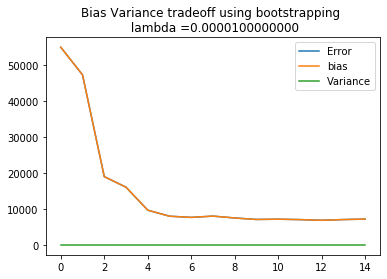

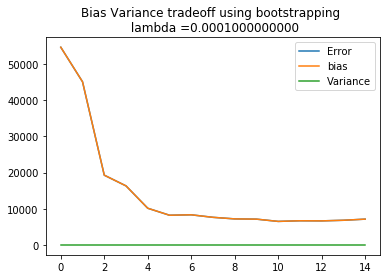

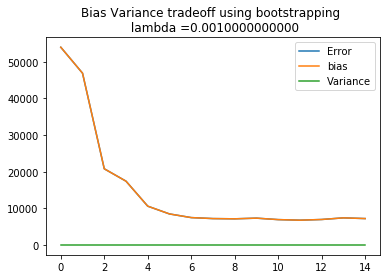

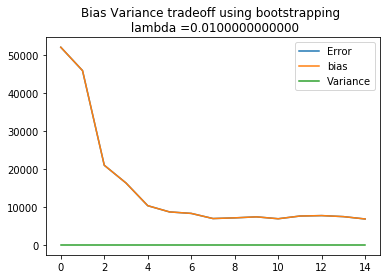

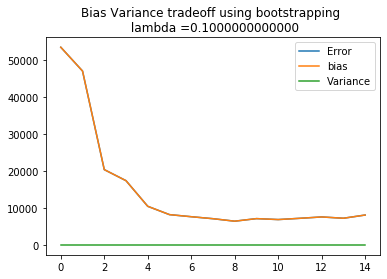

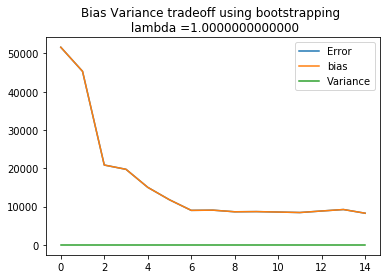

In [39]:
startpoint = 0
endpoint = 20

for k in range(len(lamb)):
    

    plt.plot(np.arange(n)[startpoint:endpoint], error[k,startpoint:endpoint], label='Error')
    plt.plot(np.arange(n)[startpoint:endpoint], bias[k,startpoint:endpoint], label='bias')
    plt.plot(np.arange(n)[startpoint:endpoint], variance[k,startpoint:endpoint], label='Variance')
    plt.title("Bias Variance tradeoff using bootstrapping \n lambda =%.13f" % lamb[k])
    plt.legend()
    #plt.ylim(-0.01, 0.1)
    plt.show()

## k-fold cross validation

In [40]:
# Initializing the data
N = 30
test_size = 0.2
n =  15

# Reducing the resolution of the data down to N x N datapoints.
x, y = np.linspace(0,1,N), np.linspace(0,1,N)
z = fn.terrain_sampling(x,y,Z)

x,y = np.meshgrid(x,y)

# Lambda
lamb = 10**np.linspace(-5,0,6)

# Bootstrap parameters
n_bootstraps = 100


# Intializing error bias and variance
error = np.zeros((len(lamb),n))
bias = np.zeros((len(lamb),n))
variance = np.zeros((len(lamb),n))



for k in range(len(lamb)):
    print("Lamdba equals {}".format(lamb[k]))
    for i in range(n):
            
        # Creating design matrix, splitting and scaling
        X_train, X_test, z_train, z_test = fn.PreProcess(x, y, z, test_size, i)

        # Setting up the array for the bootstrapped predictions
        z_pred = np.empty((z_test.shape[0], n_bootstraps))

        for j in range(n_bootstraps):
            x_, z_  = fn.Shuffle_Data(X_train, z_train)
            clf = linear_model.Lasso(alpha=lamb[k], fit_intercept=False, max_iter=500, tol=0.001)
            clf.fit(X_train, z_train)
            LASSObeta = clf.coef_
            z_pred[:,j] = X_test @ LASSObeta 

        #Reshaping
        z_test = z_test.reshape(len(z_test),1)


        error[k,i] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
        bias[k,i]  = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
        variance[k,i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

Lamdba equals 1e-05


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3207730.589428746, tolerance: 222640.412
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3207730.589428746, tolerance: 222640.412
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3207730.589428746, tolerance: 222640.412
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3207730.589428746, tolerance: 222640.412
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3207730.589428746, tolerance: 222640.412
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3207730.589428746, tolerance: 222640.412
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2452754.1881173607, tolerance: 220480.05800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2452754.1881173607, tolerance: 220480.05800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2452754.1881173607, tolerance: 220480.05800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2429602.2731954316, tolerance: 224819.55800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2429602.2731954316, tolerance: 224819.55800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2429602.2731954316, tolerance: 224819.55800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2429602.2731954316, tolerance: 224819.55800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2429602.2731954316, tolerance: 224819.55800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2429602.2731954316, tolerance: 224819.55800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2429602.2731954316, tolerance: 224819.55800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2429602.2731954316, tolerance: 224819.55800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2429602.2731954316, tolerance: 224819.55800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2392010.4343665787, tolerance: 226088.013
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2392010.4343665787, tolerance: 226088.013
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2392010.4343665787, tolerance: 226088.013
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2311683.644190449, tolerance: 223667.532
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2311683.644190449, tolerance: 223667.532
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2311683.644190449, tolerance: 223667.532
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2311683.644190449, tolerance: 223667.532
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2311683.644190449, tolerance: 223667.532
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2311683.644190449, tolerance: 223667.532
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2257430.3509917203, tolerance: 226470.98200000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2257430.3509917203, tolerance: 226470.98200000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2257430.3509917203, tolerance: 226470.98200000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2257430.3509917203, tolerance: 226470.98200000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2257430.3509917203, tolerance: 226470.98200000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2257430.3509917203, tolerance: 226470.98200000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2257430.3509917203, tolerance: 226470.98200000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2257430.3509917203, tolerance: 226470.98200000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2257430.3509917203, tolerance: 226470.98200000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2113100.945614792, tolerance: 222346.469
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2113100.945614792, tolerance: 222346.469
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2113100.945614792, tolerance: 222346.469
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2113100.945614792, tolerance: 222346.469
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2113100.945614792, tolerance: 222346.469
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2113100.945614792, tolerance: 222346.469
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2113100.945614792, tolerance: 222346.469
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2113100.945614792, tolerance: 222346.469
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2113100.945614792, tolerance: 222346.469
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2061556.9113701938, tolerance: 222360.416
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2061556.9113701938, tolerance: 222360.416
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2061556.9113701938, tolerance: 222360.416
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2061556.9113701938, tolerance: 222360.416
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2061556.9113701938, tolerance: 222360.416
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2061556.9113701938, tolerance: 222360.416
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1985894.3864200618, tolerance: 227340.356
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1985894.3864200618, tolerance: 227340.356
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1985894.3864200618, tolerance: 227340.356
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1985894.3864200618, tolerance: 227340.356
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1985894.3864200618, tolerance: 227340.356
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1985894.3864200618, tolerance: 227340.356
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1985894.3864200618, tolerance: 227340.356
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1985894.3864200618, tolerance: 227340.356
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1985894.3864200618, tolerance: 227340.356
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1845607.2333137945, tolerance: 226433.565
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1845607.2333137945, tolerance: 226433.565
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1845607.2333137945, tolerance: 226433.565
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1845607.2333137945, tolerance: 226433.565
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1845607.2333137945, tolerance: 226433.565
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1845607.2333137945, tolerance: 226433.565
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1845607.2333137945, tolerance: 226433.565
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1845607.2333137945, tolerance: 226433.565
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1845607.2333137945, tolerance: 226433.565
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678400.7369391972, tolerance: 220226.096
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678400.7369391972, tolerance: 220226.096
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678400.7369391972, tolerance: 220226.096
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678400.7369391972, tolerance: 220226.096
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678400.7369391972, tolerance: 220226.096
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678400.7369391972, tolerance: 220226.096
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678400.7369391972, tolerance: 220226.096
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678400.7369391972, tolerance: 220226.096
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678400.7369391972, tolerance: 220226.096
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1679181.8375166252, tolerance: 219597.584
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1679181.8375166252, tolerance: 219597.584
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1679181.8375166252, tolerance: 219597.584
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1679181.8375166252, tolerance: 219597.584
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1679181.8375166252, tolerance: 219597.584
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1679181.8375166252, tolerance: 219597.584
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1679181.8375166252, tolerance: 219597.584
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1679181.8375166252, tolerance: 219597.584
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1679181.8375166252, tolerance: 219597.584
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

Lamdba equals 0.0001


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3207083.120217283, tolerance: 223270.271
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3207083.120217283, tolerance: 223270.271
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3207083.120217283, tolerance: 223270.271
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3207083.120217283, tolerance: 223270.271
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3207083.120217283, tolerance: 223270.271
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3207083.120217283, tolerance: 223270.271
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2512979.6795184617, tolerance: 223782.565
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2512979.6795184617, tolerance: 223782.565
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2512979.6795184617, tolerance: 223782.565
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2313141.057025088, tolerance: 224369.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2313141.057025088, tolerance: 224369.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2313141.057025088, tolerance: 224369.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2313141.057025088, tolerance: 224369.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2313141.057025088, tolerance: 224369.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2313141.057025088, tolerance: 224369.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2313141.057025088, tolerance: 224369.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2313141.057025088, tolerance: 224369.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2313141.057025088, tolerance: 224369.63
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2223834.241932445, tolerance: 224477.56
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2223834.241932445, tolerance: 224477.56
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2223834.241932445, tolerance: 224477.56
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2366568.01410612, tolerance: 221031.959
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2366568.01410612, tolerance: 221031.959
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2366568.01410612, tolerance: 221031.959
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2366568.01410612, tolerance: 221031.959
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2366568.01410612, tolerance: 221031.959
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2366568.01410612, tolerance: 221031.959
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2258852.1876198235, tolerance: 220771.9
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2258852.1876198235, tolerance: 220771.9
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2258852.1876198235, tolerance: 220771.9
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2258852.1876198235, tolerance: 220771.9
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2258852.1876198235, tolerance: 220771.9
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2258852.1876198235, tolerance: 220771.9
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2258852.1876198235, tolerance: 220771.9
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2258852.1876198235, tolerance: 220771.9
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2258852.1876198235, tolerance: 220771.9
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2080569.5939292088, tolerance: 217911.61000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2080569.5939292088, tolerance: 217911.61000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2080569.5939292088, tolerance: 217911.61000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2080569.5939292088, tolerance: 217911.61000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2080569.5939292088, tolerance: 217911.61000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2080569.5939292088, tolerance: 217911.61000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2080569.5939292088, tolerance: 217911.61000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2080569.5939292088, tolerance: 217911.61000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2080569.5939292088, tolerance: 217911.61000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2093390.9541868297, tolerance: 226912.33000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2093390.9541868297, tolerance: 226912.33000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2093390.9541868297, tolerance: 226912.33000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2093390.9541868297, tolerance: 226912.33000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2093390.9541868297, tolerance: 226912.33000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2093390.9541868297, tolerance: 226912.33000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2093390.9541868297, tolerance: 226912.33000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2093390.9541868297, tolerance: 226912.33000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1921538.5496174821, tolerance: 226057.768
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1921538.5496174821, tolerance: 226057.768
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1921538.5496174821, tolerance: 226057.768
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1921538.5496174821, tolerance: 226057.768
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1921538.5496174821, tolerance: 226057.768
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1921538.5496174821, tolerance: 226057.768
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1921538.5496174821, tolerance: 226057.768
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878052.34250072, tolerance: 225044.606
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878052.34250072, tolerance: 225044.606
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878052.34250072, tolerance: 225044.606
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878052.34250072, tolerance: 225044.606
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878052.34250072, tolerance: 225044.606
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878052.34250072, tolerance: 225044.606
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878052.34250072, tolerance: 225044.606
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878052.34250072, tolerance: 225044.606
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878052.34250072, tolerance: 225044.606
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878052.34250072, tolerance: 225044.606
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878052.34250072, tolerance: 225044.606
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1878052.34250072, tolerance: 225044.606
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1706093.4673178603, tolerance: 219300.457
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1706093.4673178603, tolerance: 219300.457
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1706093.4673178603, tolerance: 219300.457
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1706093.4673178603, tolerance: 219300.457
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1706093.4673178603, tolerance: 219300.457
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1706093.4673178603, tolerance: 219300.457
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1764682.1500263216, tolerance: 225276.207
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1764682.1500263216, tolerance: 225276.207
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1764682.1500263216, tolerance: 225276.207
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1764682.1500263216, tolerance: 225276.207
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1764682.1500263216, tolerance: 225276.207
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1764682.1500263216, tolerance: 225276.207
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1764682.1500263216, tolerance: 225276.207
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1764682.1500263216, tolerance: 225276.207
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1764682.1500263216, tolerance: 225276.207
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1764682.1500263216, tolerance: 225276.207
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1764682.1500263216, tolerance: 225276.207
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1764682.1500263216, tolerance: 225276.207
  positive)


Lamdba equals 0.001


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3206213.1672853613, tolerance: 220153.146
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3206213.1672853613, tolerance: 220153.146
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3206213.1672853613, tolerance: 220153.146
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3206213.1672853613, tolerance: 220153.146
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3206213.1672853613, tolerance: 220153.146
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3206213.1672853613, tolerance: 220153.146
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2529328.800552339, tolerance: 222640.527
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2529328.800552339, tolerance: 222640.527
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2529328.800552339, tolerance: 222640.527
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2295914.4039270063, tolerance: 223871.90600000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2295914.4039270063, tolerance: 223871.90600000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2295914.4039270063, tolerance: 223871.90600000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2295914.4039270063, tolerance: 223871.90600000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2295914.4039270063, tolerance: 223871.90600000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2295914.4039270063, tolerance: 223871.90600000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2295914.4039270063, tolerance: 223871.90600000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2295914.4039270063, tolerance: 223871.90600000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2295914.4039270063, tolerance: 223871.90600000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2387034.684545177, tolerance: 224713.2
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2387034.684545177, tolerance: 224713.2
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2387034.684545177, tolerance: 224713.2
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2387034.684545177, tolerance: 224713.2
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2387034.684545177, tolerance: 224713.2
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2387034.684545177, tolerance: 224713.2
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2404824.139297241, tolerance: 224283.622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2404824.139297241, tolerance: 224283.622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2404824.139297241, tolerance: 224283.622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2404824.139297241, tolerance: 224283.622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2404824.139297241, tolerance: 224283.622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2404824.139297241, tolerance: 224283.622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2255680.6529062246, tolerance: 222512.863
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2255680.6529062246, tolerance: 222512.863
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2255680.6529062246, tolerance: 222512.863
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2255680.6529062246, tolerance: 222512.863
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2255680.6529062246, tolerance: 222512.863
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2255680.6529062246, tolerance: 222512.863
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2123694.716382767, tolerance: 223110.441
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2123694.716382767, tolerance: 223110.441
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2123694.716382767, tolerance: 223110.441
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2123694.716382767, tolerance: 223110.441
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2123694.716382767, tolerance: 223110.441
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2123694.716382767, tolerance: 223110.441
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2123694.716382767, tolerance: 223110.441
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2123694.716382767, tolerance: 223110.441
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2123694.716382767, tolerance: 223110.441
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2011269.1146852255, tolerance: 220875.916
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2011269.1146852255, tolerance: 220875.916
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2011269.1146852255, tolerance: 220875.916
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2011269.1146852255, tolerance: 220875.916
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2011269.1146852255, tolerance: 220875.916
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2011269.1146852255, tolerance: 220875.916
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2011269.1146852255, tolerance: 220875.916
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2011269.1146852255, tolerance: 220875.916
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2011269.1146852255, tolerance: 220875.916
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1872624.399450865, tolerance: 220709.836
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1872624.399450865, tolerance: 220709.836
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1872624.399450865, tolerance: 220709.836
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1872624.399450865, tolerance: 220709.836
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1872624.399450865, tolerance: 220709.836
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1872624.399450865, tolerance: 220709.836
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1825092.5085474479, tolerance: 225204.317
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1825092.5085474479, tolerance: 225204.317
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1825092.5085474479, tolerance: 225204.317
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1825092.5085474479, tolerance: 225204.317
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1825092.5085474479, tolerance: 225204.317
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1825092.5085474479, tolerance: 225204.317
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1825092.5085474479, tolerance: 225204.317
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1825092.5085474479, tolerance: 225204.317
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1825092.5085474479, tolerance: 225204.317
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1802530.5490215442, tolerance: 224925.066
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1802530.5490215442, tolerance: 224925.066
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1802530.5490215442, tolerance: 224925.066
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1802530.5490215442, tolerance: 224925.066
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1802530.5490215442, tolerance: 224925.066
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1802530.5490215442, tolerance: 224925.066
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1802530.5490215442, tolerance: 224925.066
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1802530.5490215442, tolerance: 224925.066
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1802530.5490215442, tolerance: 224925.066
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1758818.0962704024, tolerance: 228841.66400000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1758818.0962704024, tolerance: 228841.66400000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1758818.0962704024, tolerance: 228841.66400000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1758818.0962704024, tolerance: 228841.66400000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1758818.0962704024, tolerance: 228841.66400000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1758818.0962704024, tolerance: 228841.66400000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1758818.0962704024, tolerance: 228841.66400000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1758818.0962704024, tolerance: 228841.66400000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1758818.0962704024, tolerance: 228841.66400000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

Lamdba equals 0.01


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2945135.61889643, tolerance: 225919.02000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2945135.61889643, tolerance: 225919.02000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2945135.61889643, tolerance: 225919.02000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2945135.61889643, tolerance: 225919.02000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2945135.61889643, tolerance: 225919.02000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2945135.61889643, tolerance: 225919.02000000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2263793.2922618855, tolerance: 218978.484
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2263793.2922618855, tolerance: 218978.484
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2263793.2922618855, tolerance: 218978.484
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2087779.7271060837, tolerance: 224220.162
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2087779.7271060837, tolerance: 224220.162
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2087779.7271060837, tolerance: 224220.162
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2087779.7271060837, tolerance: 224220.162
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2087779.7271060837, tolerance: 224220.162
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2087779.7271060837, tolerance: 224220.162
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2087779.7271060837, tolerance: 224220.162
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2094503.6235500998, tolerance: 221790.90600000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2094503.6235500998, tolerance: 221790.90600000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective di

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2094503.6235500998, tolerance: 221790.90600000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2094503.6235500998, tolerance: 221790.90600000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2094503.6235500998, tolerance: 221790.90600000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2301219.944995261, tolerance: 222286.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2301219.944995261, tolerance: 222286.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2301219.944995261, tolerance: 222286.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2301219.944995261, tolerance: 222286.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2301219.944995261, tolerance: 222286.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2301219.944995261, tolerance: 222286.047
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2149330.172841646, tolerance: 222503.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2149330.172841646, tolerance: 222503.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2149330.172841646, tolerance: 222503.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2149330.172841646, tolerance: 222503.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2149330.172841646, tolerance: 222503.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2149330.172841646, tolerance: 222503.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2149330.172841646, tolerance: 222503.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2149330.172841646, tolerance: 222503.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2149330.172841646, tolerance: 222503.015
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2015719.9934716185, tolerance: 221270.033
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2015719.9934716185, tolerance: 221270.033
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2015719.9934716185, tolerance: 221270.033
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2015719.9934716185, tolerance: 221270.033
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2015719.9934716185, tolerance: 221270.033
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2015719.9934716185, tolerance: 221270.033
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2015719.9934716185, tolerance: 221270.033
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2015719.9934716185, tolerance: 221270.033
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2015719.9934716185, tolerance: 221270.033
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1924606.1213427621, tolerance: 217786.693
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1924606.1213427621, tolerance: 217786.693
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1924606.1213427621, tolerance: 217786.693
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1924606.1213427621, tolerance: 217786.693
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1924606.1213427621, tolerance: 217786.693
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1924606.1213427621, tolerance: 217786.693
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1826972.3463482915, tolerance: 220518.45
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1826972.3463482915, tolerance: 220518.45
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1826972.3463482915, tolerance: 220518.45
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1826972.3463482915, tolerance: 220518.45
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1826972.3463482915, tolerance: 220518.45
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1826972.3463482915, tolerance: 220518.45
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1826972.3463482915, tolerance: 220518.45
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1826972.3463482915, tolerance: 220518.45
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1826972.3463482915, tolerance: 220518.45
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1757432.9254925798, tolerance: 224570.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1757432.9254925798, tolerance: 224570.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1757432.9254925798, tolerance: 224570.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1757432.9254925798, tolerance: 224570.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1757432.9254925798, tolerance: 224570.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1757432.9254925798, tolerance: 224570.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1757432.9254925798, tolerance: 224570.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1757432.9254925798, tolerance: 224570.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1757432.9254925798, tolerance: 224570.601
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1717987.4162332632, tolerance: 221620.353
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1717987.4162332632, tolerance: 221620.353
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1717987.4162332632, tolerance: 221620.353
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1717987.4162332632, tolerance: 221620.353
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1717987.4162332632, tolerance: 221620.353
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1717987.4162332632, tolerance: 221620.353
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1717987.4162332632, tolerance: 221620.353
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1717987.4162332632, tolerance: 221620.353
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1717987.4162332632, tolerance: 221620.353
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1710925.4322787765, tolerance: 225549.802
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1710925.4322787765, tolerance: 225549.802
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1710925.4322787765, tolerance: 225549.802
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1710925.4322787765, tolerance: 225549.802
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1710925.4322787765, tolerance: 225549.802
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1710925.4322787765, tolerance: 225549.802
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1710925.4322787765, tolerance: 225549.802
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1710925.4322787765, tolerance: 225549.802
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1710925.4322787765, tolerance: 225549.802
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

Lamdba equals 0.1


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2615186.7623067563, tolerance: 219316.698
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2615186.7623067563, tolerance: 219316.698
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2615186.7623067563, tolerance: 219316.698
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2615186.7623067563, tolerance: 219316.698
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2615186.7623067563, tolerance: 219316.698
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2615186.7623067563, tolerance: 219316.698
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1930419.646754351, tolerance: 226822.429
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1930419.646754351, tolerance: 226822.429
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1930419.646754351, tolerance: 226822.429
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 872403.849534929, tolerance: 223950.795
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 872403.849534929, tolerance: 223950.795
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 872403.849534929, tolerance: 223950.795
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 872403.849534929, tolerance: 223950.795
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 872403.849534929, tolerance: 223950.795
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 872403.849534929, tolerance: 223950.795
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 872403.849534929, tolerance: 223950.795
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 872403.849534929, tolerance: 223950.795
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 872403.849534929, tolerance: 223950.795
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1105615.946762448, tolerance: 221763.39800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1105615.946762448, tolerance: 221763.39800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1105615.946762448, tolerance: 221763.39800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objecti

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1105615.946762448, tolerance: 221763.39800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1105615.946762448, tolerance: 221763.39800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1105615.946762448, tolerance: 221763.39800000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objecti

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1450061.3981587014, tolerance: 220464.875
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1450061.3981587014, tolerance: 220464.875
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1450061.3981587014, tolerance: 220464.875
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1450061.3981587014, tolerance: 220464.875
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1450061.3981587014, tolerance: 220464.875
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1450061.3981587014, tolerance: 220464.875
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1695460.0729758895, tolerance: 221070.818
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1695460.0729758895, tolerance: 221070.818
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1695460.0729758895, tolerance: 221070.818
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1695460.0729758895, tolerance: 221070.818
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1695460.0729758895, tolerance: 221070.818
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1695460.0729758895, tolerance: 221070.818
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1699621.4084040178, tolerance: 222589.101
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1699621.4084040178, tolerance: 222589.101
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1699621.4084040178, tolerance: 222589.101
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1699621.4084040178, tolerance: 222589.101
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1699621.4084040178, tolerance: 222589.101
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1699621.4084040178, tolerance: 222589.101
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1699621.4084040178, tolerance: 222589.101
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1699621.4084040178, tolerance: 222589.101
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1699621.4084040178, tolerance: 222589.101
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1355272.0292201051, tolerance: 226909.28900000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1355272.0292201051, tolerance: 226909.28900000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1355272.0292201051, tolerance: 226909.28900000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1355272.0292201051, tolerance: 226909.28900000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1355272.0292201051, tolerance: 226909.28900000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1355272.0292201051, tolerance: 226909.28900000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1355272.0292201051, tolerance: 226909.28900000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1355272.0292201051, tolerance: 226909.28900000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1355272.0292201051, tolerance: 226909.28900000002
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Obje

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1340355.1947880217, tolerance: 222213.75
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1340355.1947880217, tolerance: 222213.75
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1340355.1947880217, tolerance: 222213.75
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1340355.1947880217, tolerance: 222213.75
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1340355.1947880217, tolerance: 222213.75
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1340355.1947880217, tolerance: 222213.75
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1340355.1947880217, tolerance: 222213.75
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1340355.1947880217, tolerance: 222213.75
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1340355.1947880217, tolerance: 222213.75
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1232979.8604080528, tolerance: 222999.315
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1232979.8604080528, tolerance: 222999.315
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1232979.8604080528, tolerance: 222999.315
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1232979.8604080528, tolerance: 222999.315
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1232979.8604080528, tolerance: 222999.315
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1232979.8604080528, tolerance: 222999.315
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1232979.8604080528, tolerance: 222999.315
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1232979.8604080528, tolerance: 222999.315
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1232979.8604080528, tolerance: 222999.315
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196673.9902464051, tolerance: 225021.987
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196673.9902464051, tolerance: 225021.987
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196673.9902464051, tolerance: 225021.987
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196673.9902464051, tolerance: 225021.987
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196673.9902464051, tolerance: 225021.987
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196673.9902464051, tolerance: 225021.987
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196673.9902464051, tolerance: 225021.987
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196673.9902464051, tolerance: 225021.987
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196673.9902464051, tolerance: 225021.987
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1098643.30536144, tolerance: 225862.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1098643.30536144, tolerance: 225862.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1098643.30536144, tolerance: 225862.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1098643.30536144, tolerance: 225862.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1098643.30536144, tolerance: 225862.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1098643.30536144, tolerance: 225862.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1098643.30536144, tolerance: 225862.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1098643.30536144, tolerance: 225862.165
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1098643.30536144, tolerance: 225862.165
  positive)


Lamdba equals 1.0


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252310.04037374863, tolerance: 225395.527
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252310.04037374863, tolerance: 225395.527
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252310.04037374863, tolerance: 225395.527
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252310.04037374863, tolerance: 225395.527
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252310.04037374863, tolerance: 225395.527
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252310.04037374863, tolerance: 225395.527
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252310.04037374863, tolerance: 225395.527
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252310.04037374863, tolerance: 225395.527
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252310.04037374863, tolerance: 225395.527
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252310.04037374863, tolerance: 225395.527
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252310.04037374863, tolerance: 225395.527
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252310.04037374863, tolerance: 225395.527
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313047.3260214026, tolerance: 223141.774
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313047.3260214026, tolerance: 223141.774
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313047.3260214026, tolerance: 223141.774
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313047.3260214026, tolerance: 223141.774
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313047.3260214026, tolerance: 223141.774
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313047.3260214026, tolerance: 223141.774
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351776.9593889974, tolerance: 223024.622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351776.9593889974, tolerance: 223024.622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351776.9593889974, tolerance: 223024.622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351776.9593889974, tolerance: 223024.622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351776.9593889974, tolerance: 223024.622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351776.9593889974, tolerance: 223024.622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351776.9593889974, tolerance: 223024.622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351776.9593889974, tolerance: 223024.622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351776.9593889974, tolerance: 223024.622
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 403629.4949708171, tolerance: 219677.861
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 403629.4949708171, tolerance: 219677.861
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 403629.4949708171, tolerance: 219677.861
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 403629.4949708171, tolerance: 219677.861
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 403629.4949708171, tolerance: 219677.861
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 403629.4949708171, tolerance: 219677.861
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 403629.4949708171, tolerance: 219677.861
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 403629.4949708171, tolerance: 219677.861
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 403629.4949708171, tolerance: 219677.861
  positive)
C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You

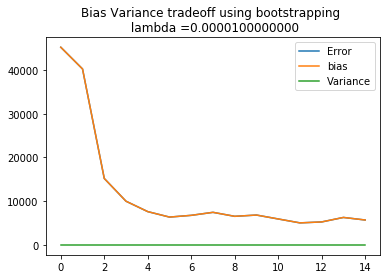

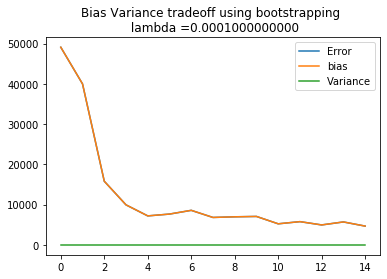

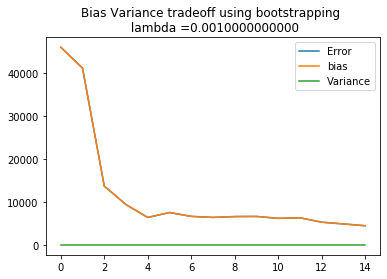

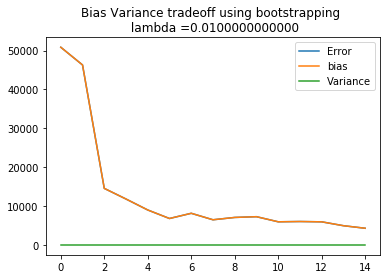

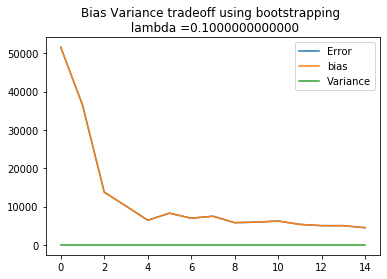

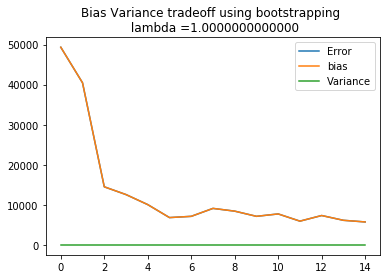

In [41]:
startpoint = 0
endpoint = 20

for k in range(len(lamb)):
    

    plt.plot(np.arange(n)[startpoint:endpoint], error[k,startpoint:endpoint], label='Error')
    plt.plot(np.arange(n)[startpoint:endpoint], bias[k,startpoint:endpoint], label='bias')
    plt.plot(np.arange(n)[startpoint:endpoint], variance[k,startpoint:endpoint], label='Variance')
    plt.title("Bias Variance tradeoff using bootstrapping \n lambda =%.13f" % lamb[k])
    plt.legend()
    #plt.ylim(-0.01, 0.1)
    plt.show()